In [1]:
from io import BytesIO
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from feature_utils import normalize_histogram

In [2]:
# Read the parquet file, this takes a while. Leave it here
features_file = Path("data/train_features.parquet")
if not features_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

meta_file = Path("data/meta_full.parquet")
if not meta_file.exists():
    print("No features file found. Please run the create_features_table first")
    exit(1)

dft = pl.read_parquet(features_file, use_pyarrow=True, memory_map=True)
dfm = pl.read_parquet(meta_file, use_pyarrow=True, memory_map=True)
dft = dft.join(dfm, on="ClassId")
del dfm

Class:			0 
Description:		Max limit (20 km/h)
Number of samples:	210


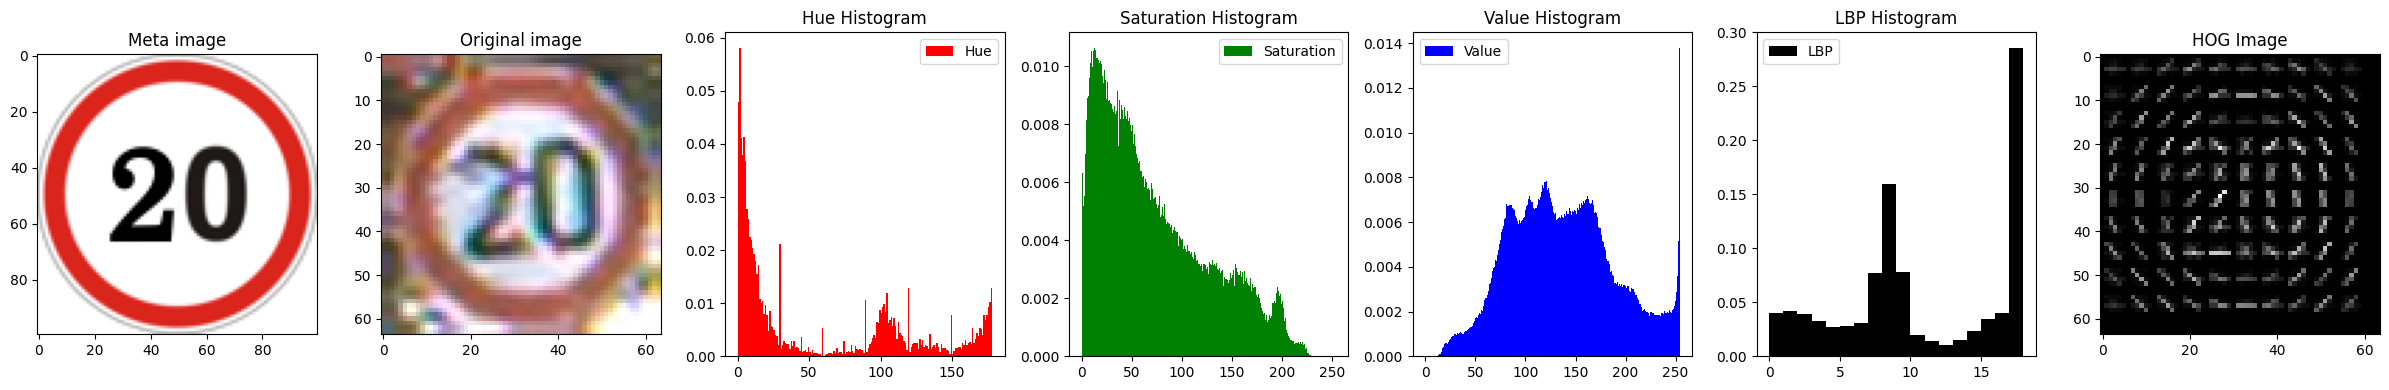

Class:			1 
Description:		Max limit (30 km/h)
Number of samples:	2220


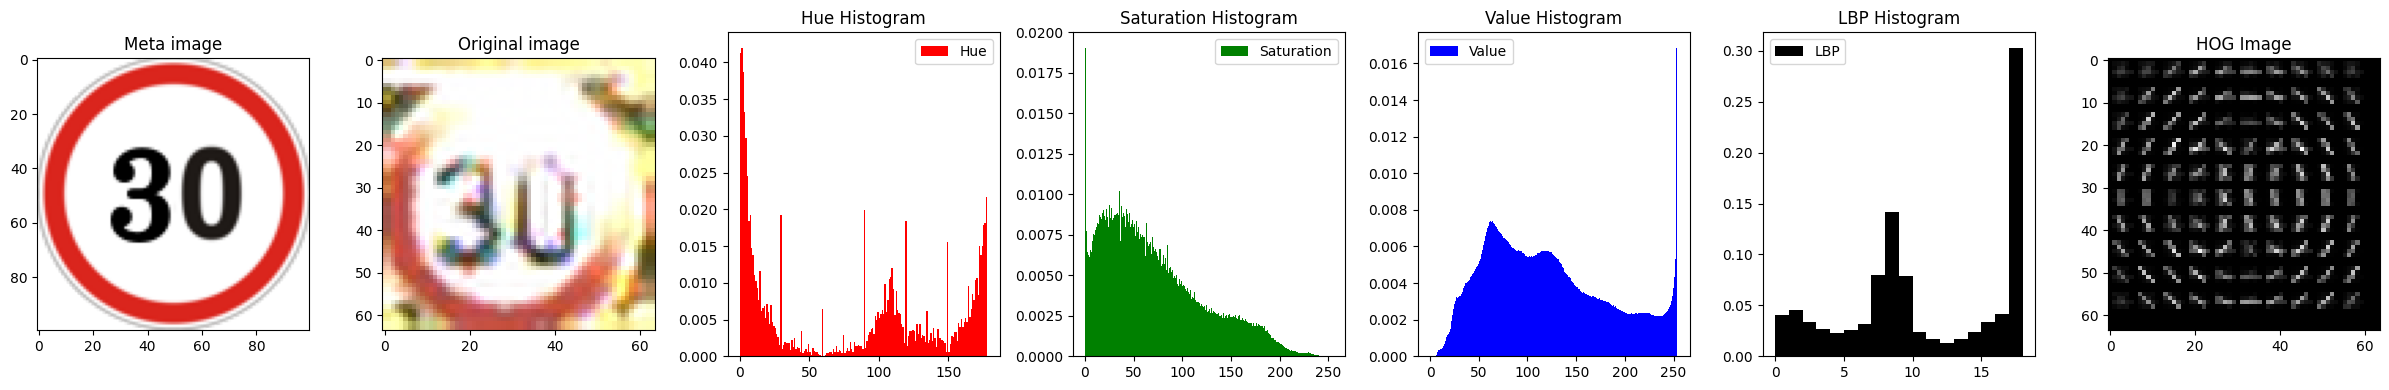

Class:			2 
Description:		Max limit (50 km/h)
Number of samples:	2250


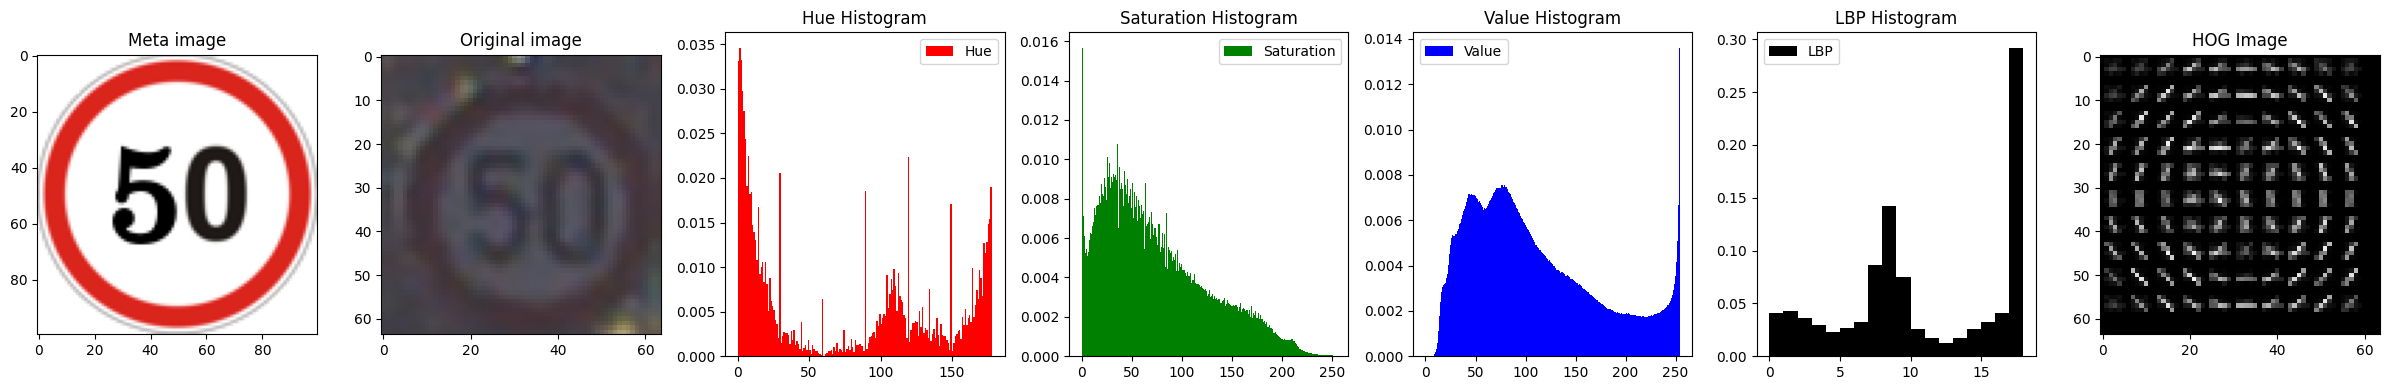

Class:			3 
Description:		Max limit (60 km/h)
Number of samples:	1410


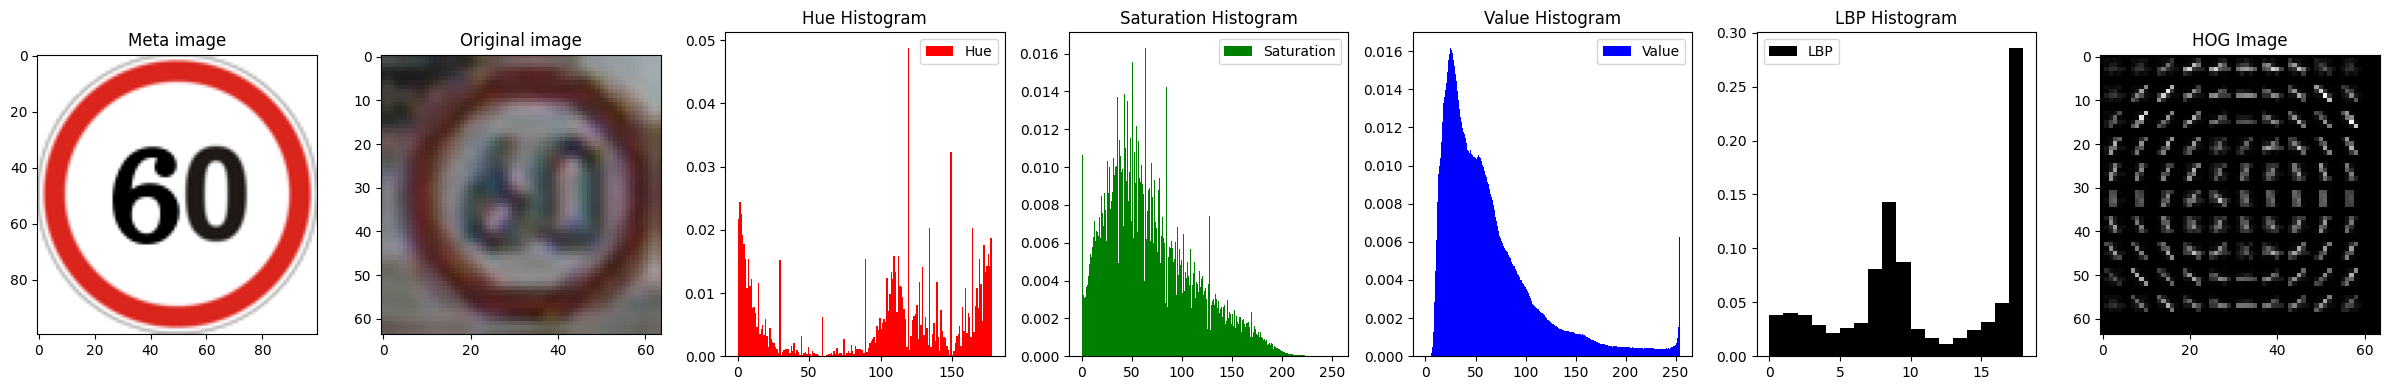

Class:			4 
Description:		Max limit (70 km/h)
Number of samples:	1980


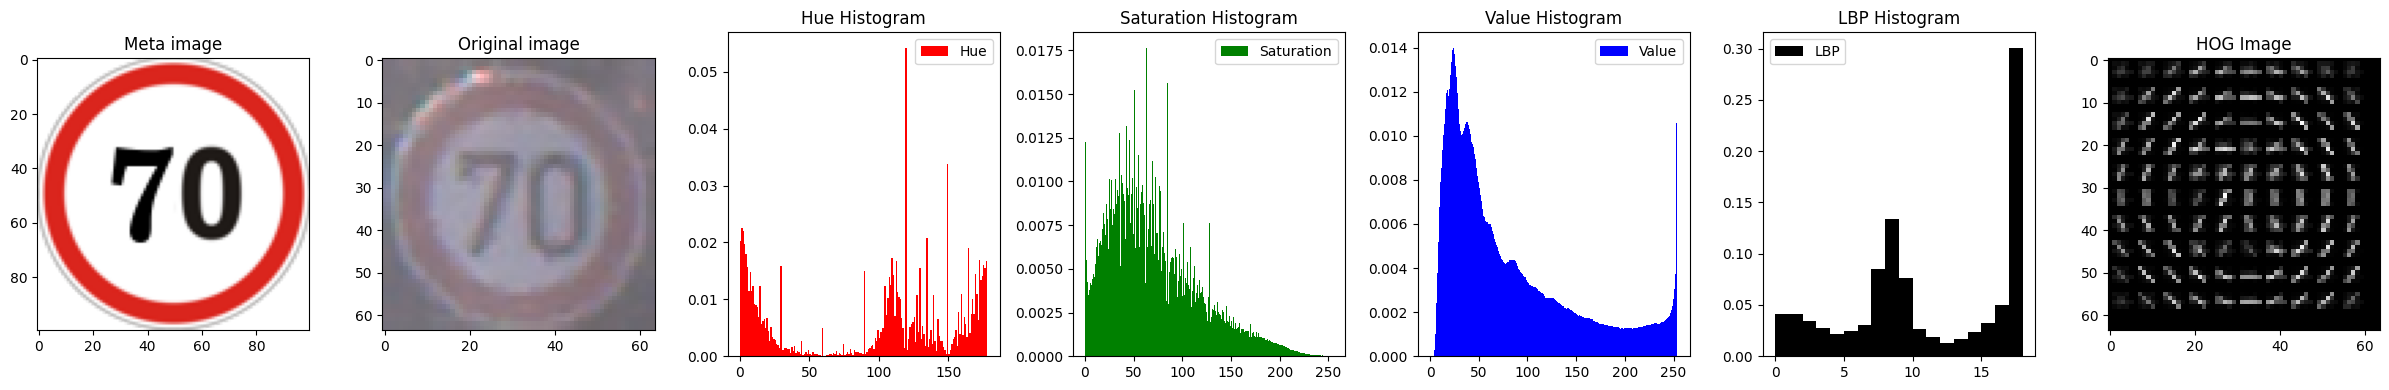

Class:			5 
Description:		Max limit (80 km/h)
Number of samples:	1860


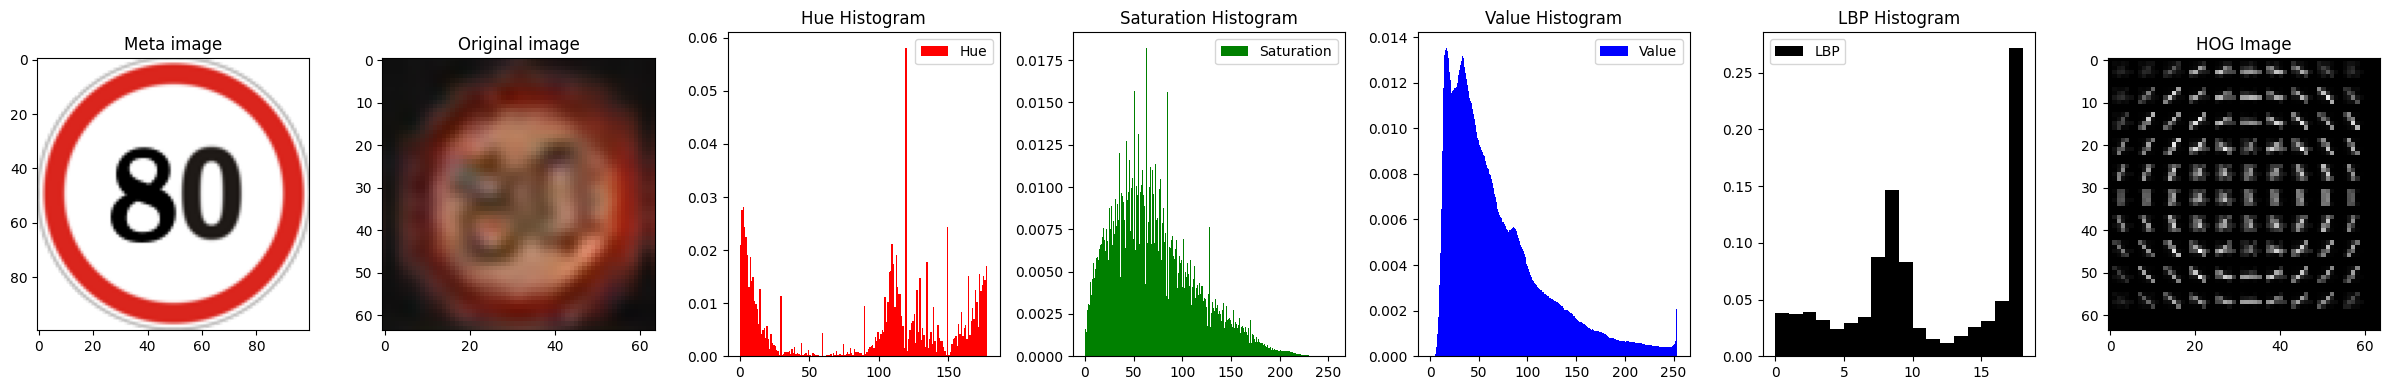

Class:			6 
Description:		End of limit (80 km/h)
Number of samples:	420


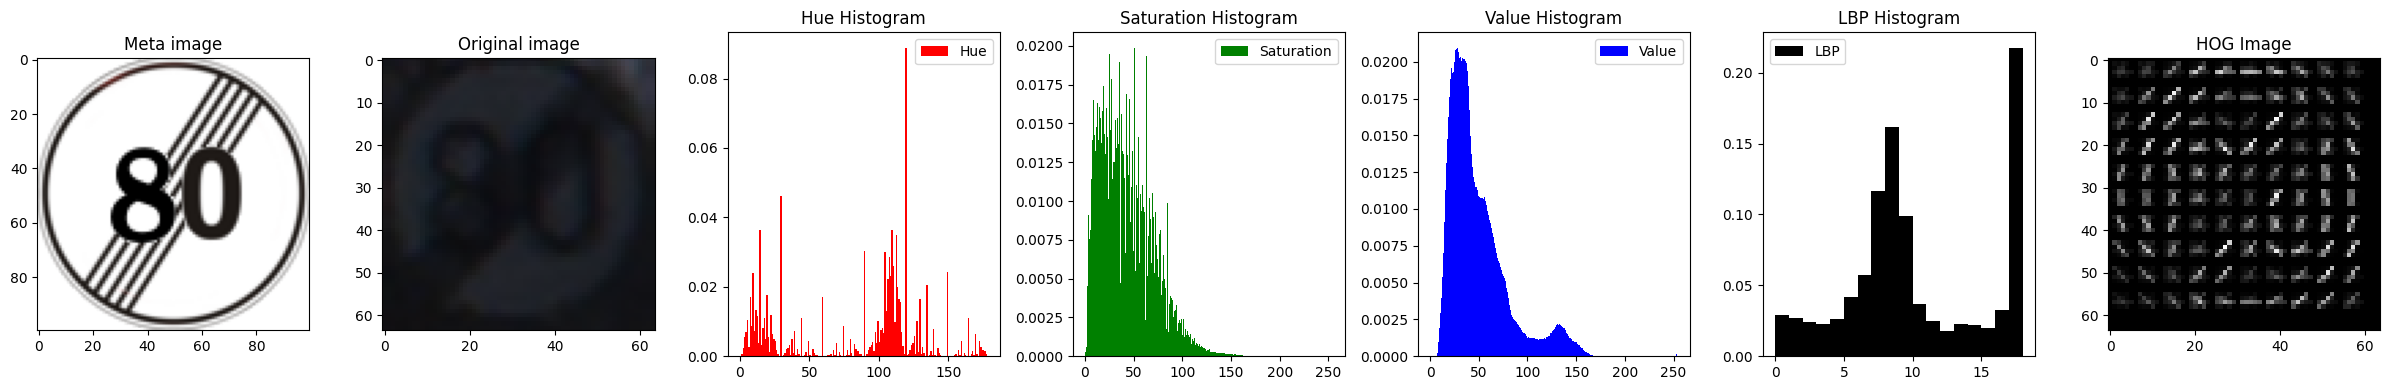

Class:			7 
Description:		Max limit (100 km/h)
Number of samples:	1440


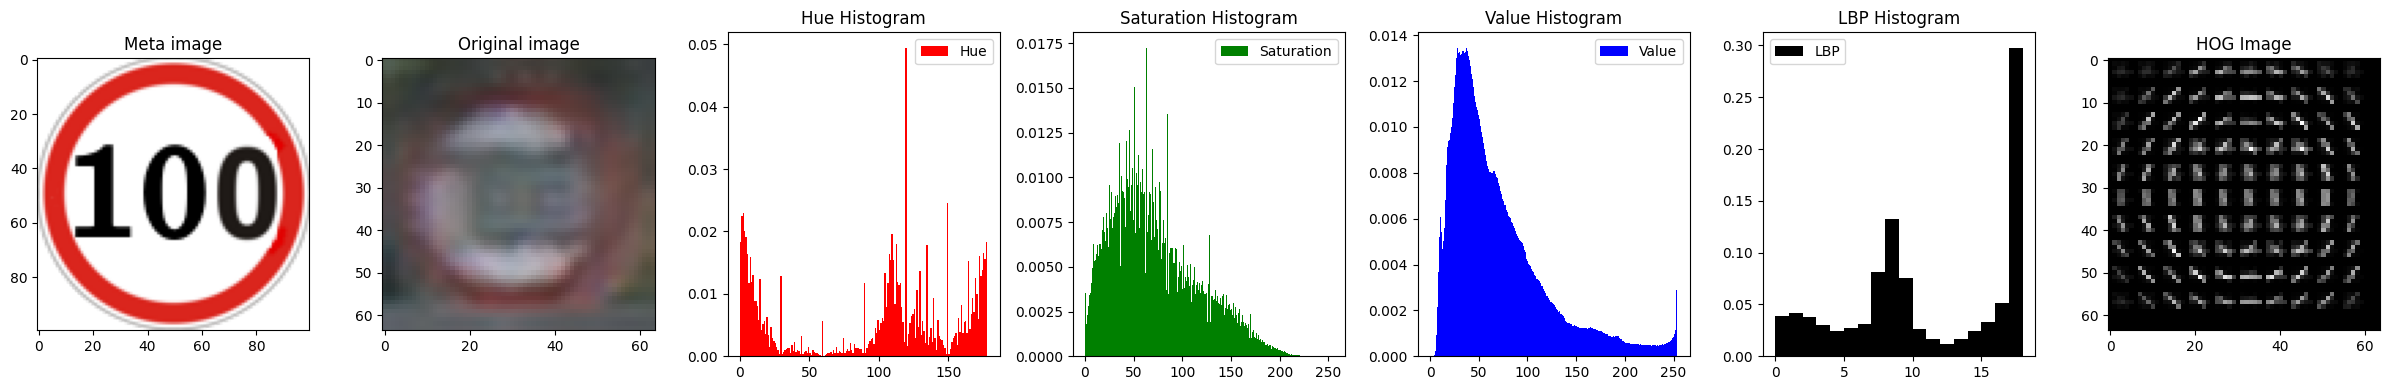

Class:			8 
Description:		Max limit (120 km/h)
Number of samples:	1410


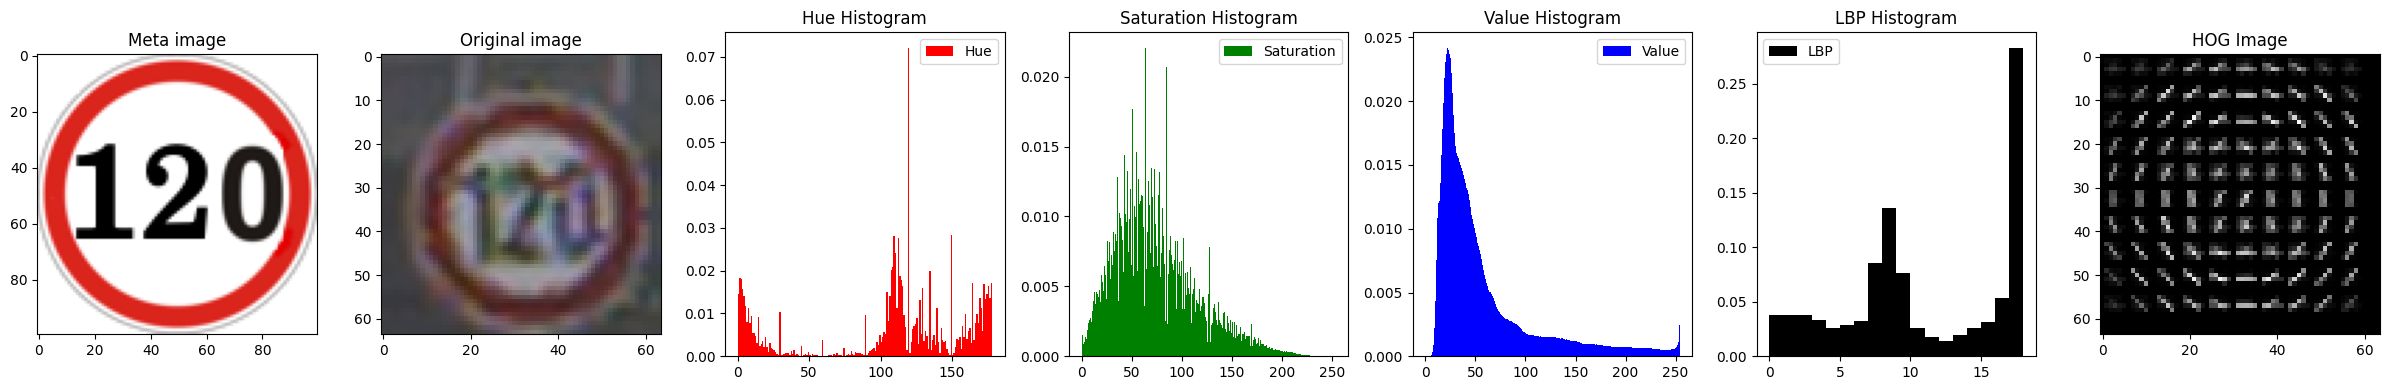

Class:			9 
Description:		No passing (except bike/mopeds/mcycles)
Number of samples:	1470


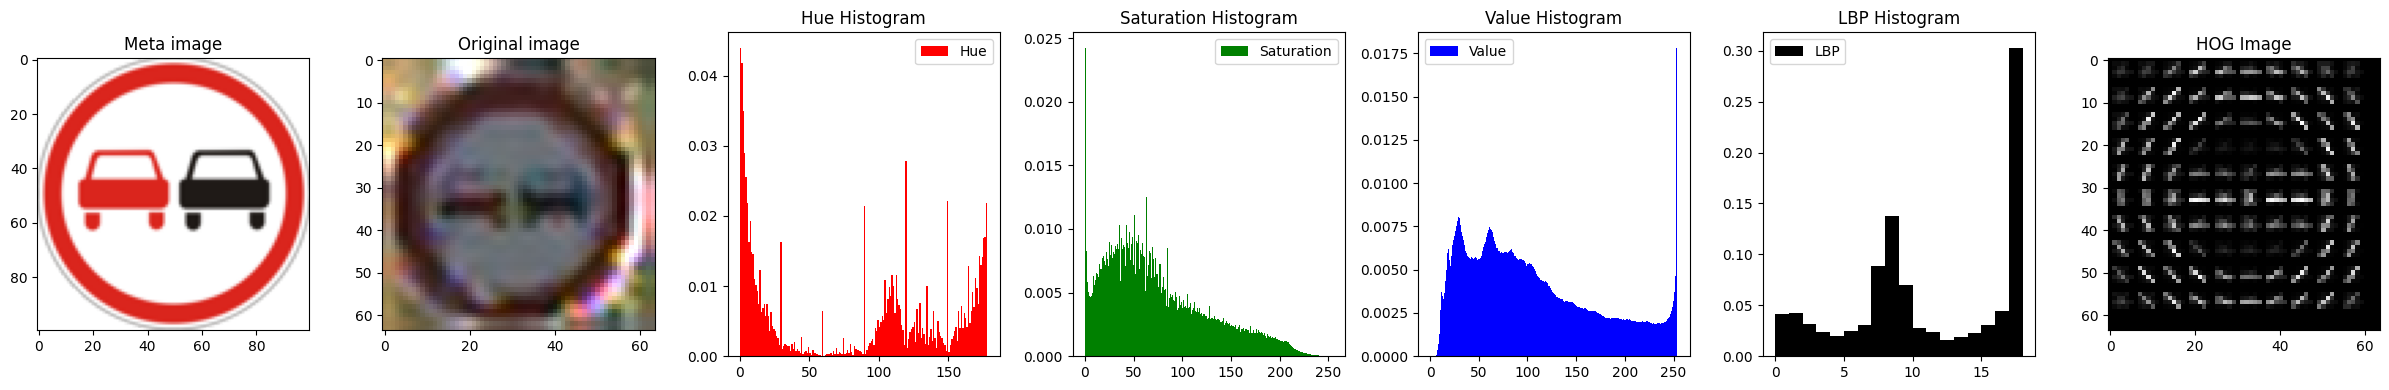

Class:			10 
Description:		No passing over 3.5  tons
Number of samples:	2010


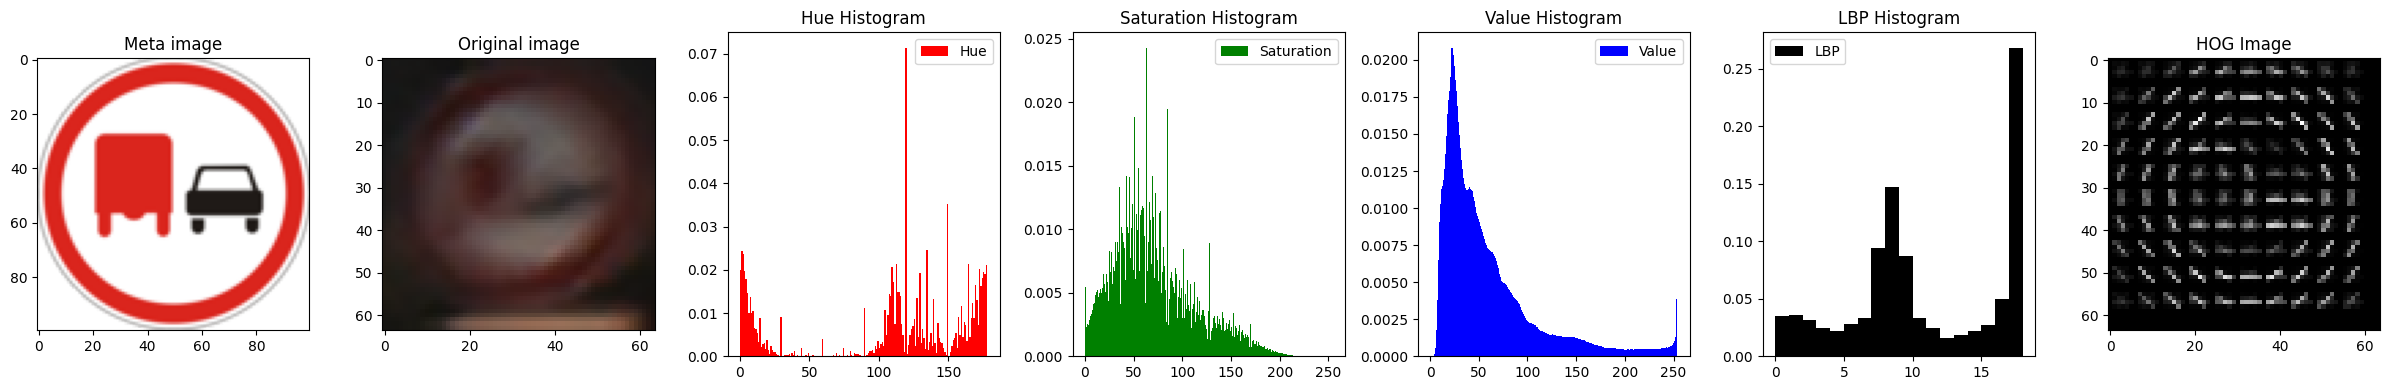

Class:			11 
Description:		Right of way at next intersection
Number of samples:	1320


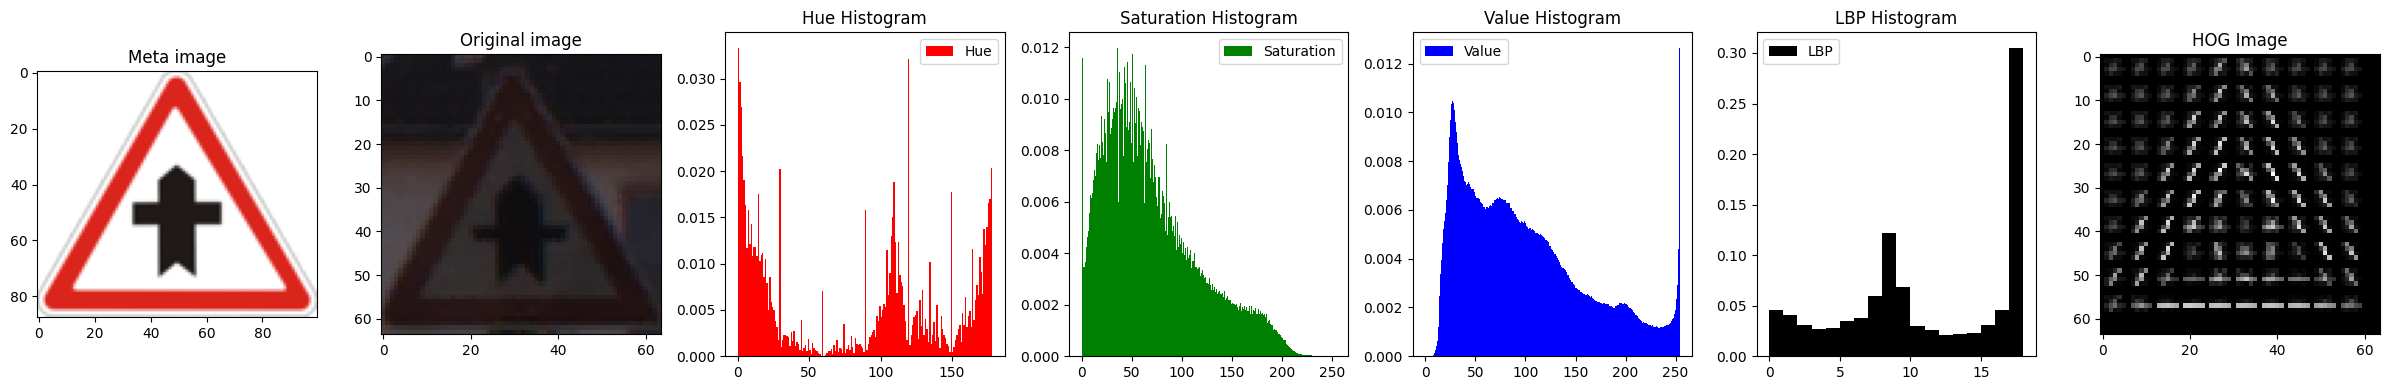

Class:			12 
Description:		Right of way at all intersections)
Number of samples:	2100


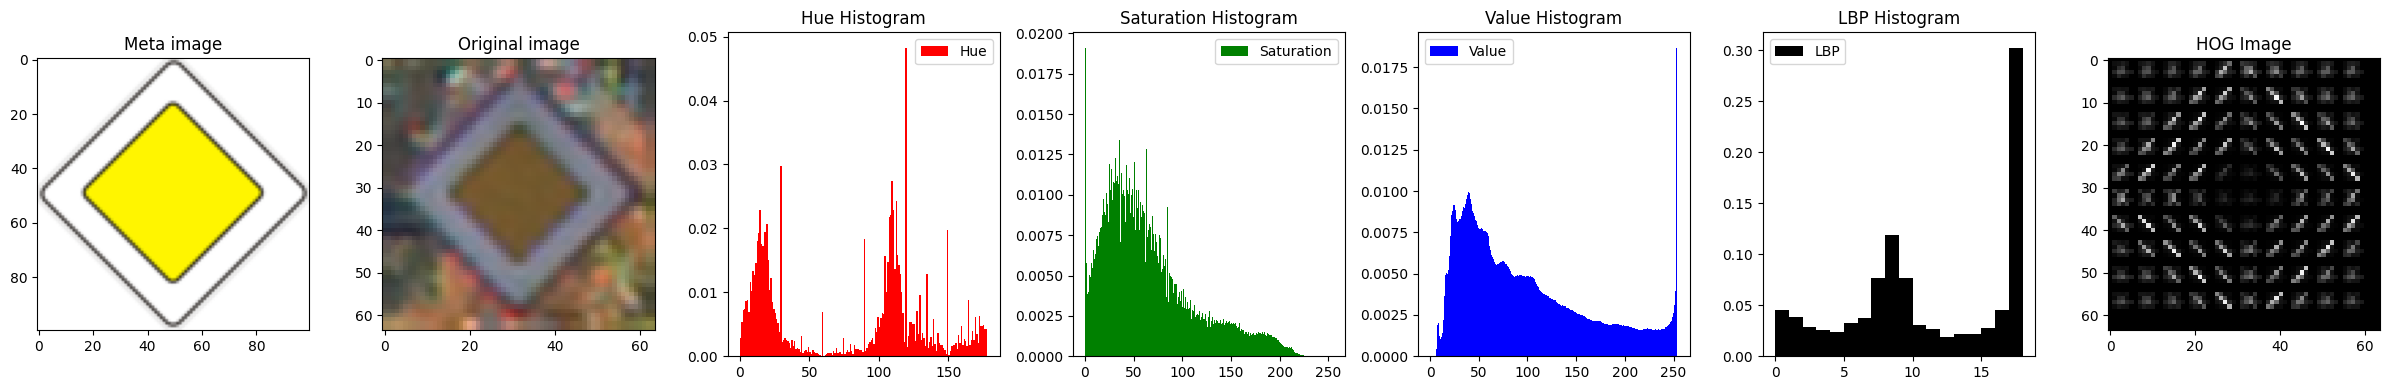

Class:			13 
Description:		Yield
Number of samples:	2160


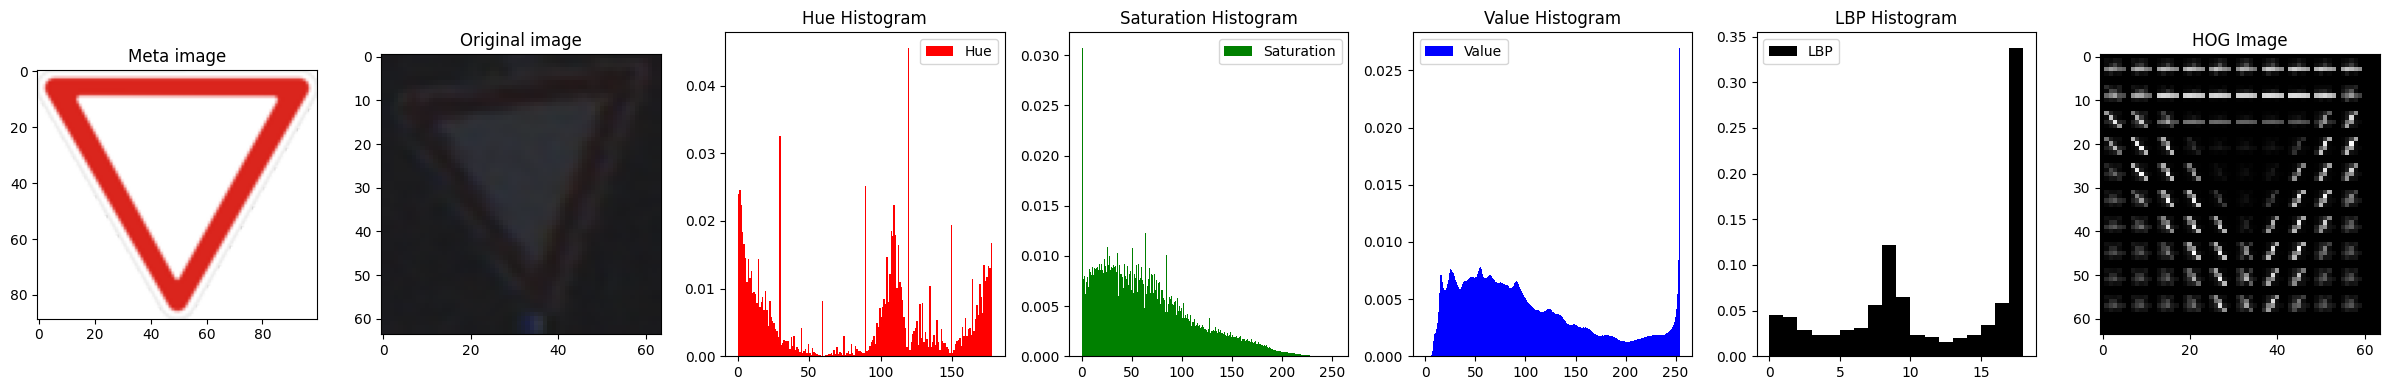

Class:			14 
Description:		Stop
Number of samples:	780


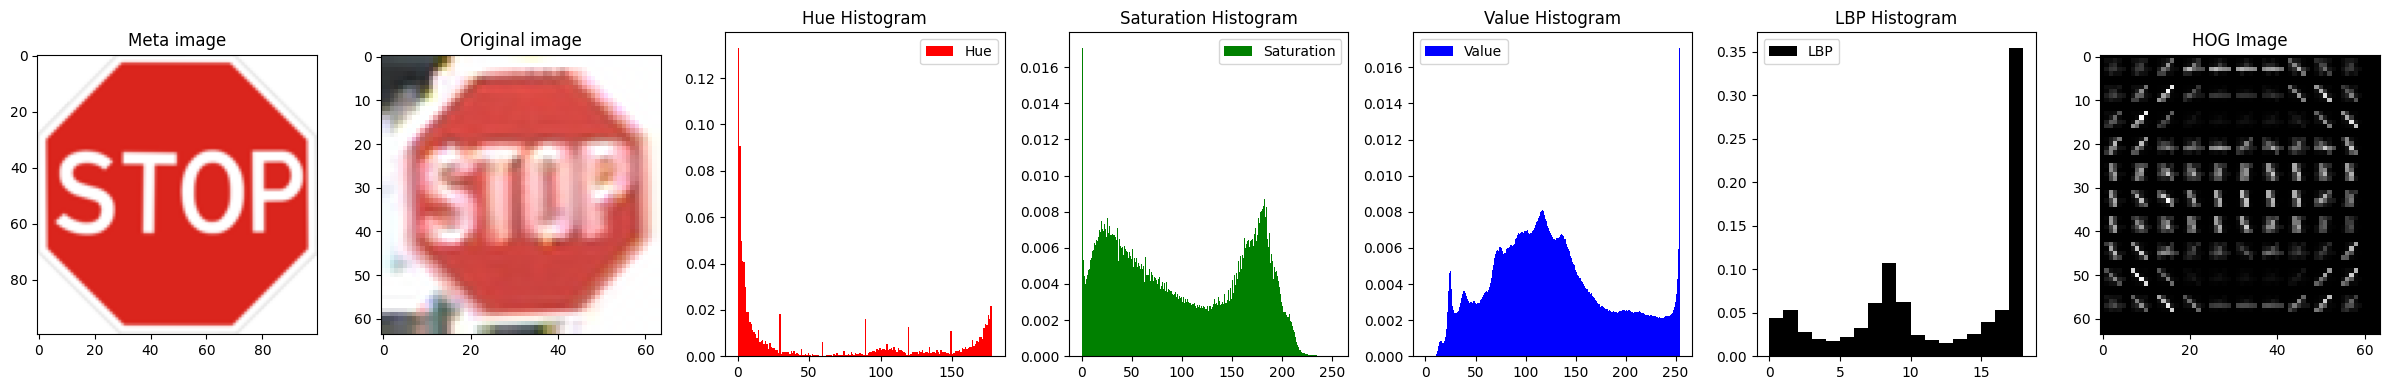

Class:			15 
Description:		Road closed
Number of samples:	630


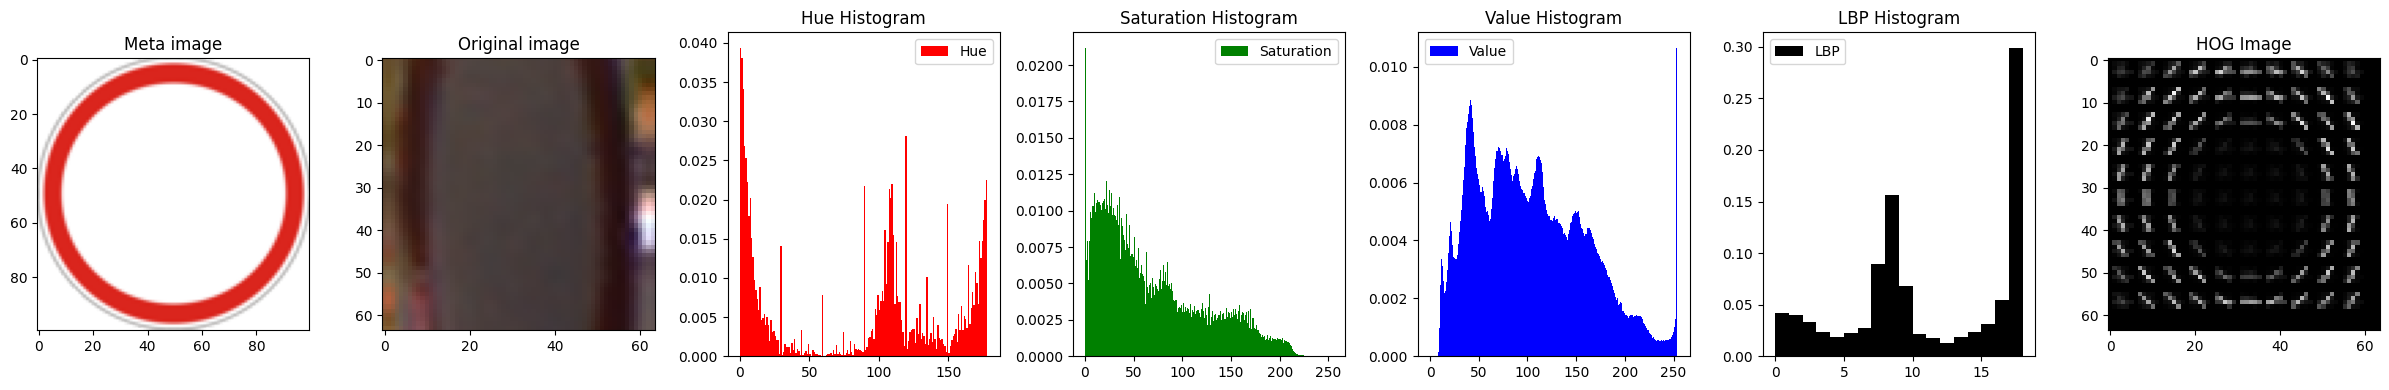

Class:			16 
Description:		Over 3.5 Tons prohibited
Number of samples:	420


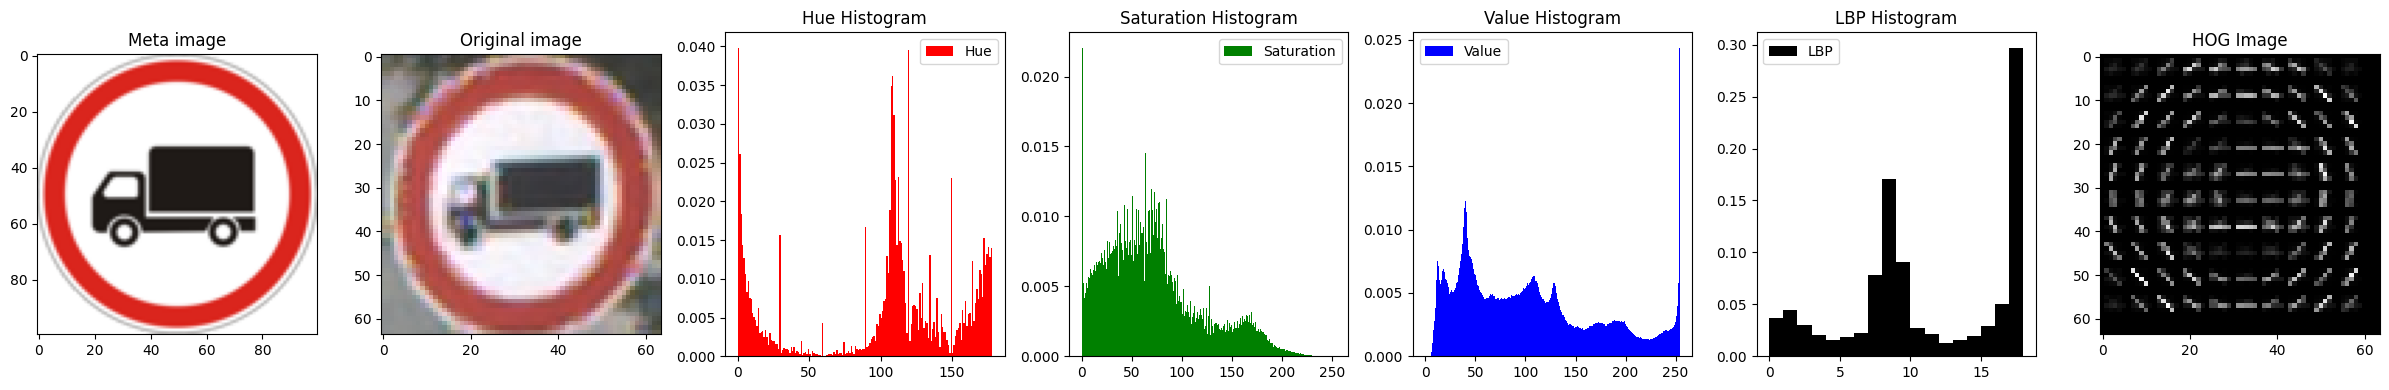

Class:			17 
Description:		Do not enter
Number of samples:	1110


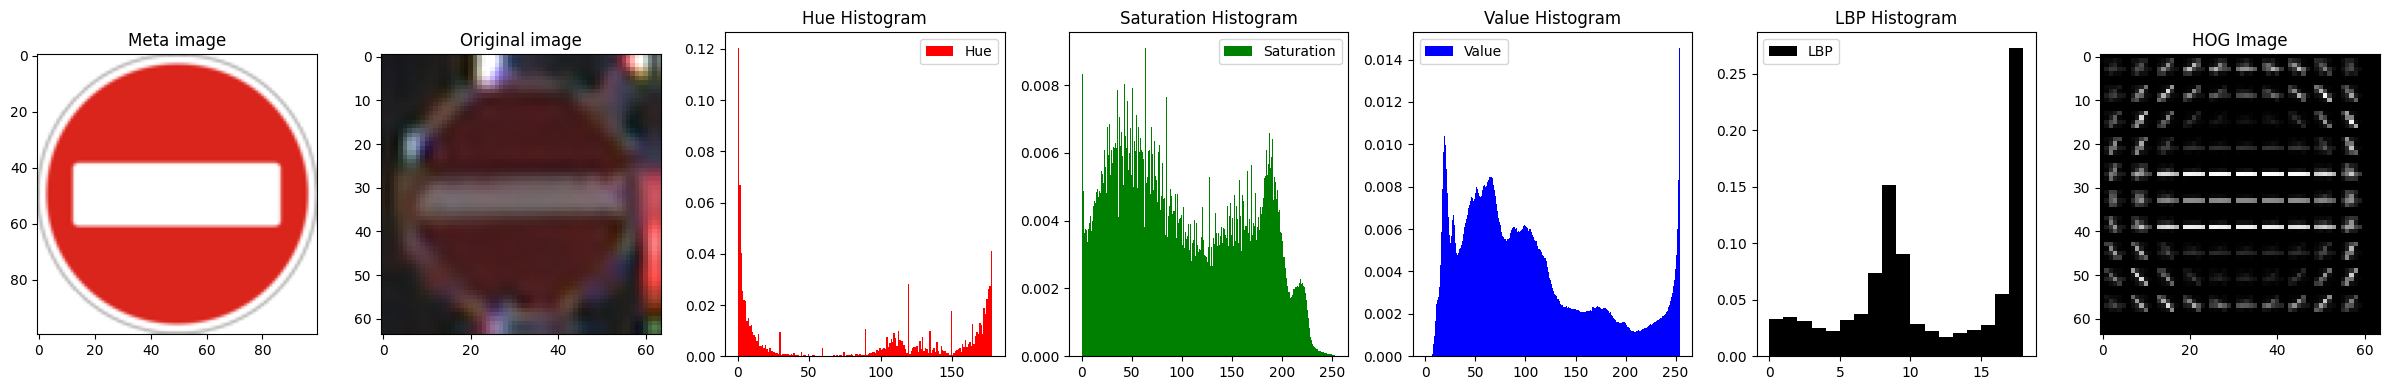

Class:			18 
Description:		General danger
Number of samples:	1200


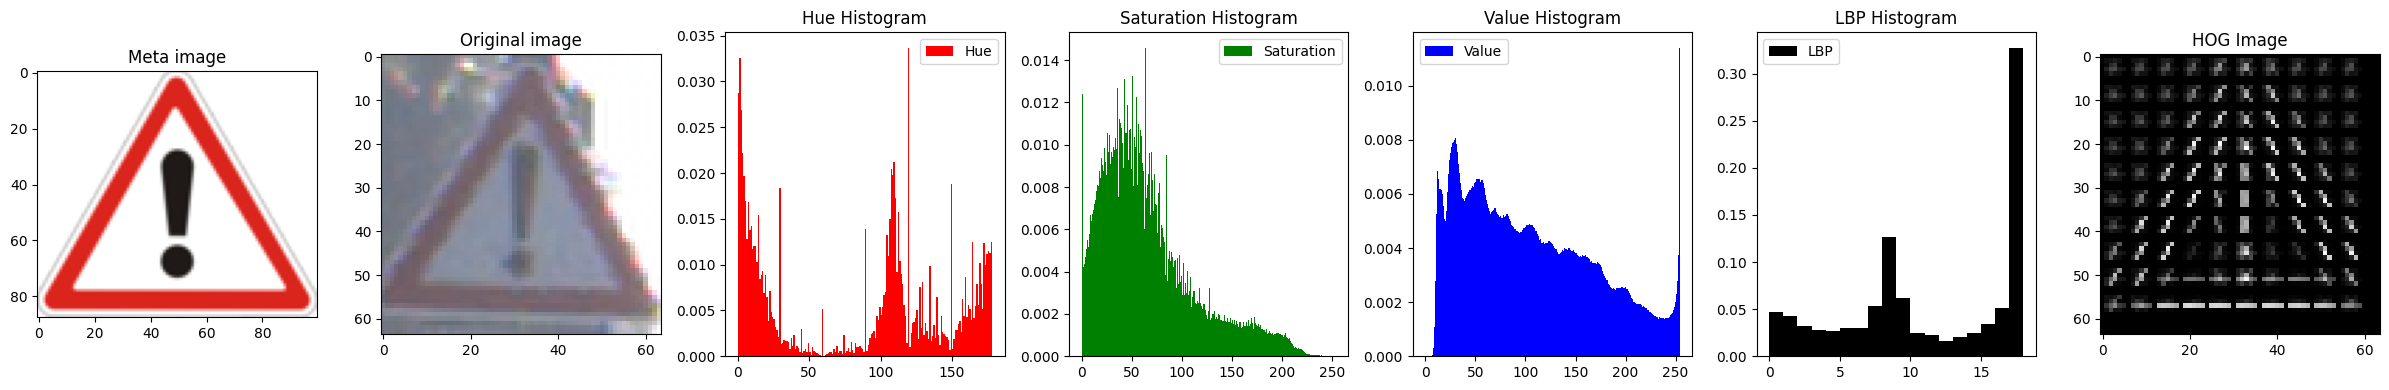

Class:			19 
Description:		Left curve
Number of samples:	210


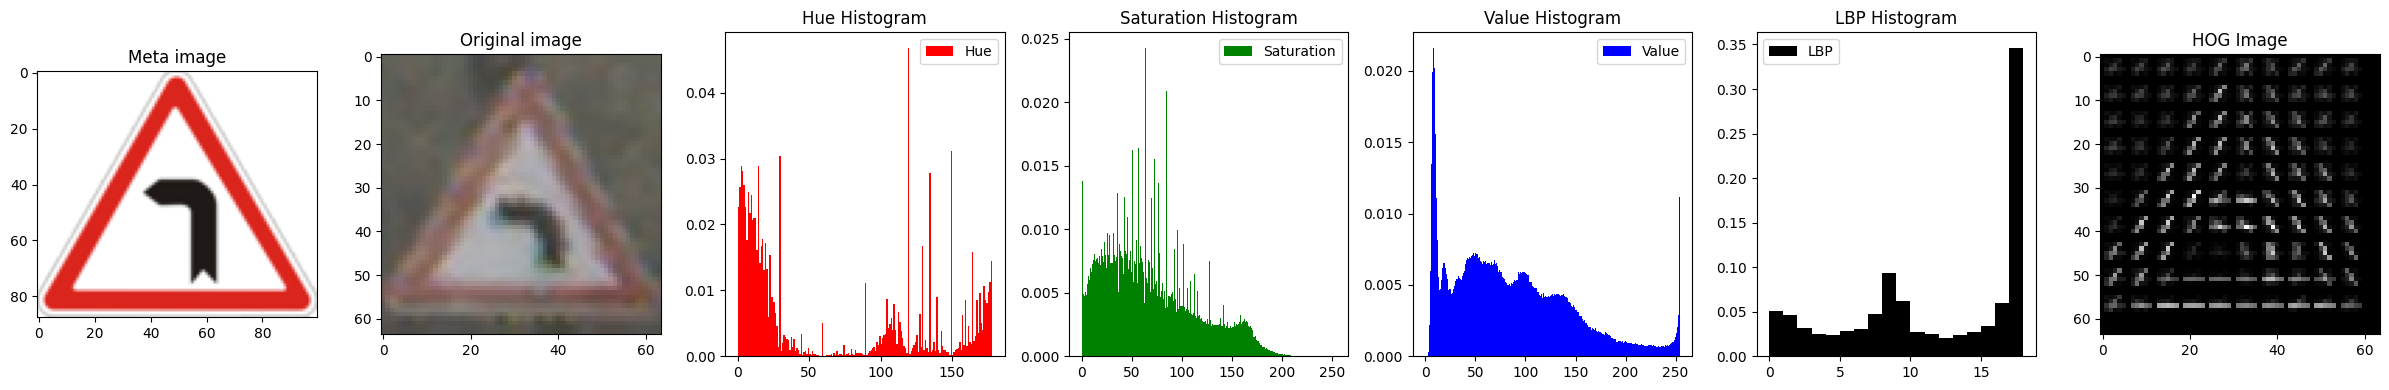

Class:			20 
Description:		Right curve
Number of samples:	360


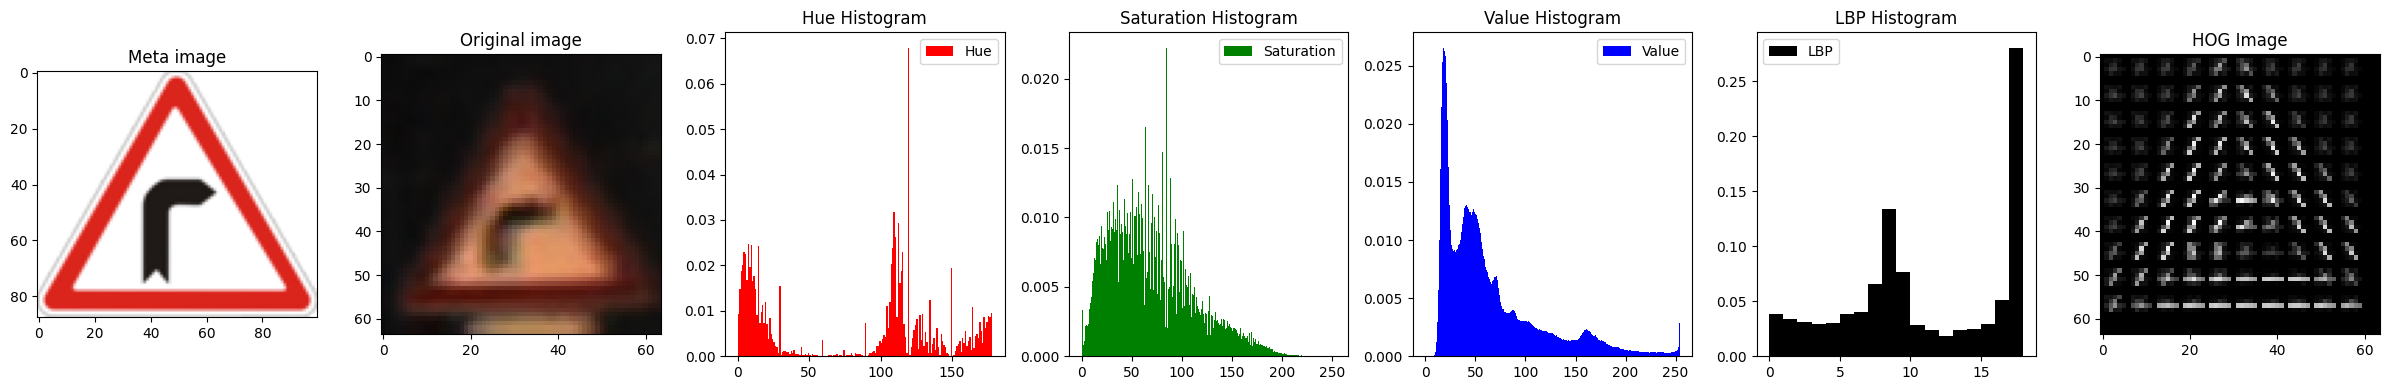

Class:			21 
Description:		Double curve
Number of samples:	330


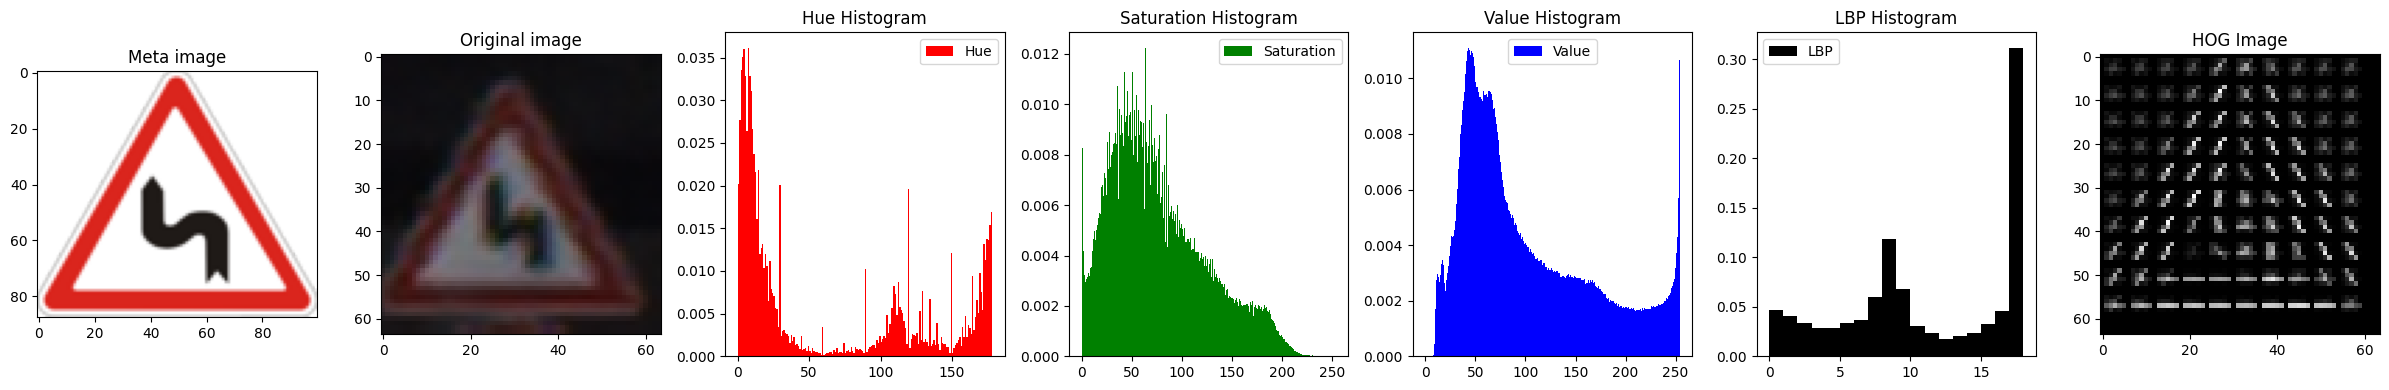

Class:			22 
Description:		Uneven road surface
Number of samples:	390


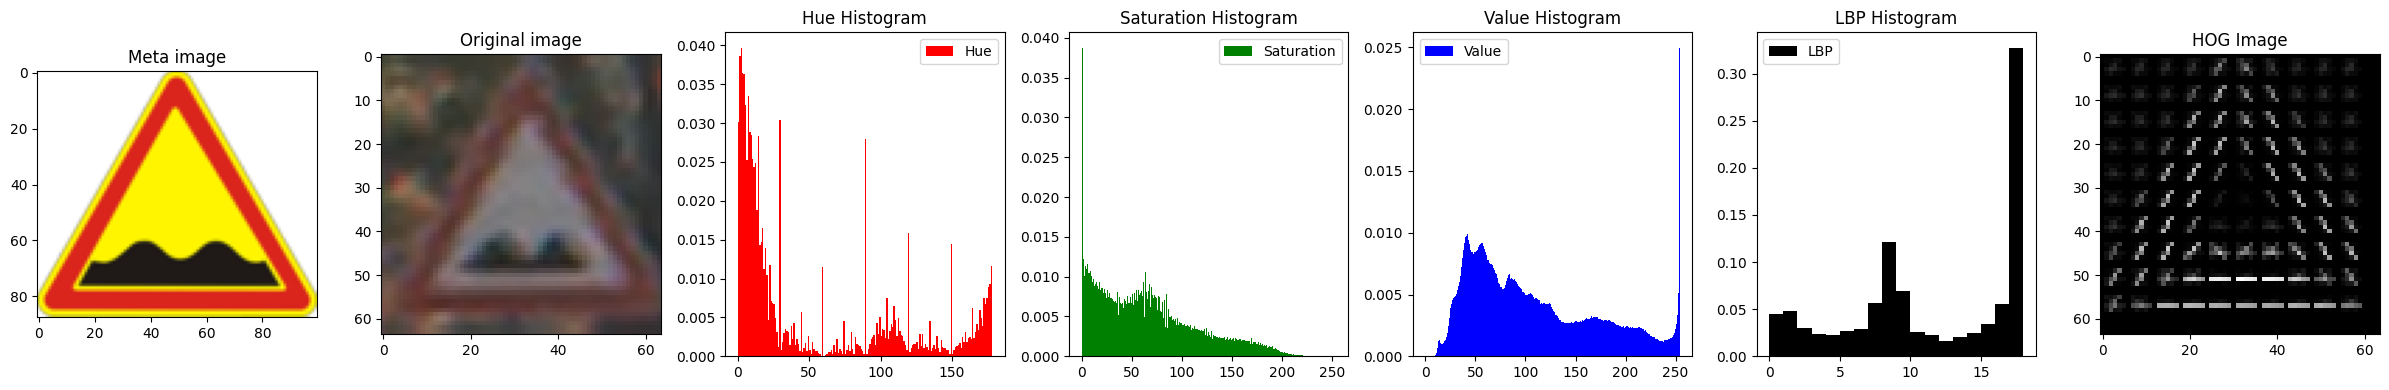

Class:			23 
Description:		Slippery when wet/dirty
Number of samples:	510


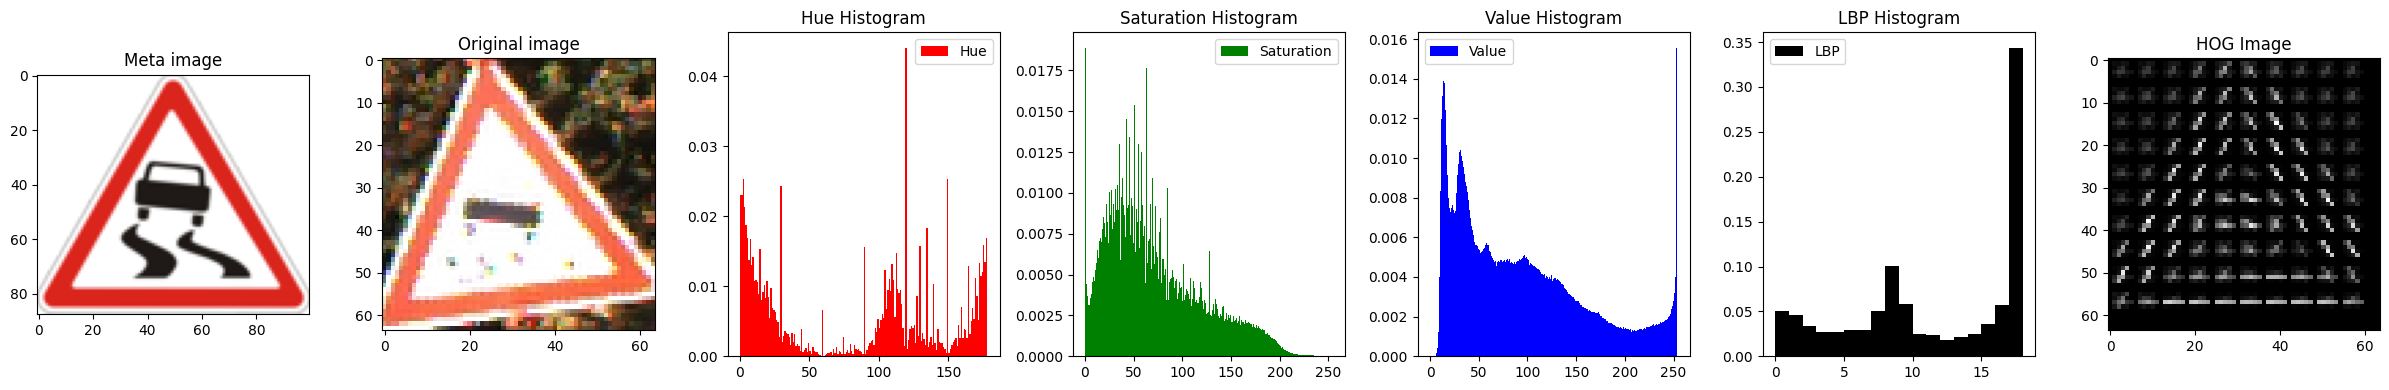

Class:			24 
Description:		Road narrows
Number of samples:	270


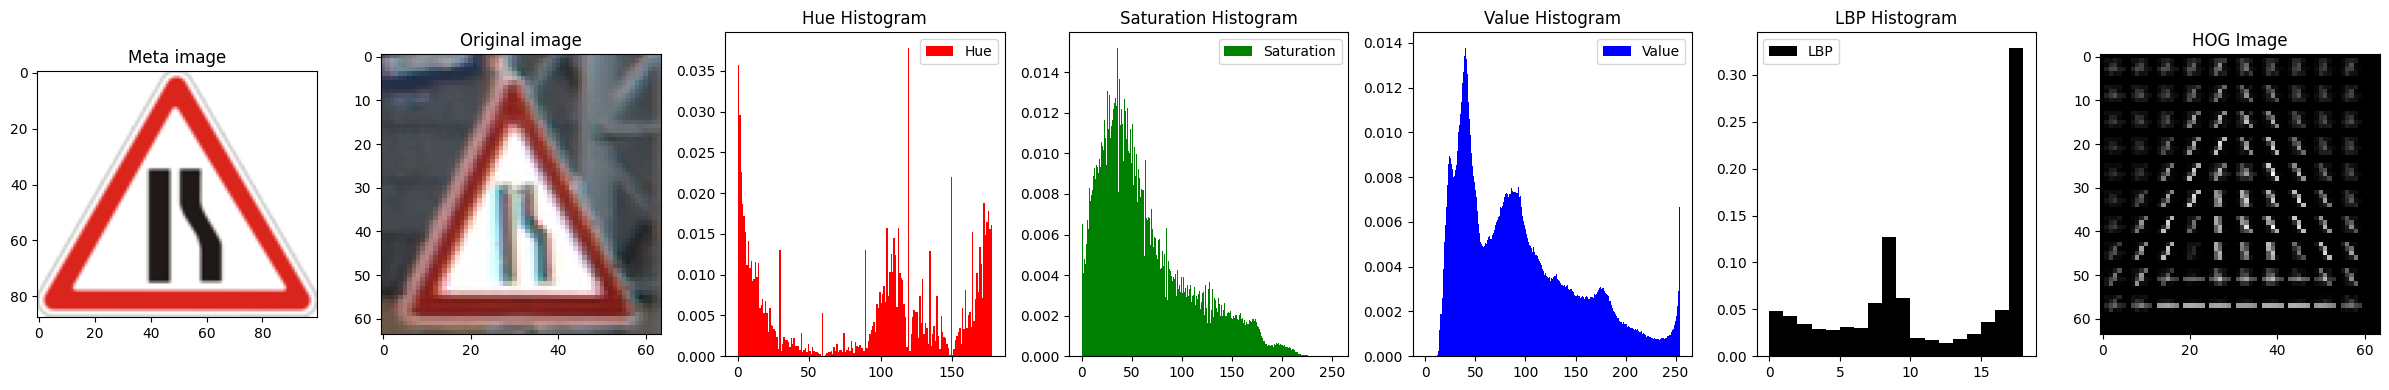

Class:			25 
Description:		Roadworks
Number of samples:	1500


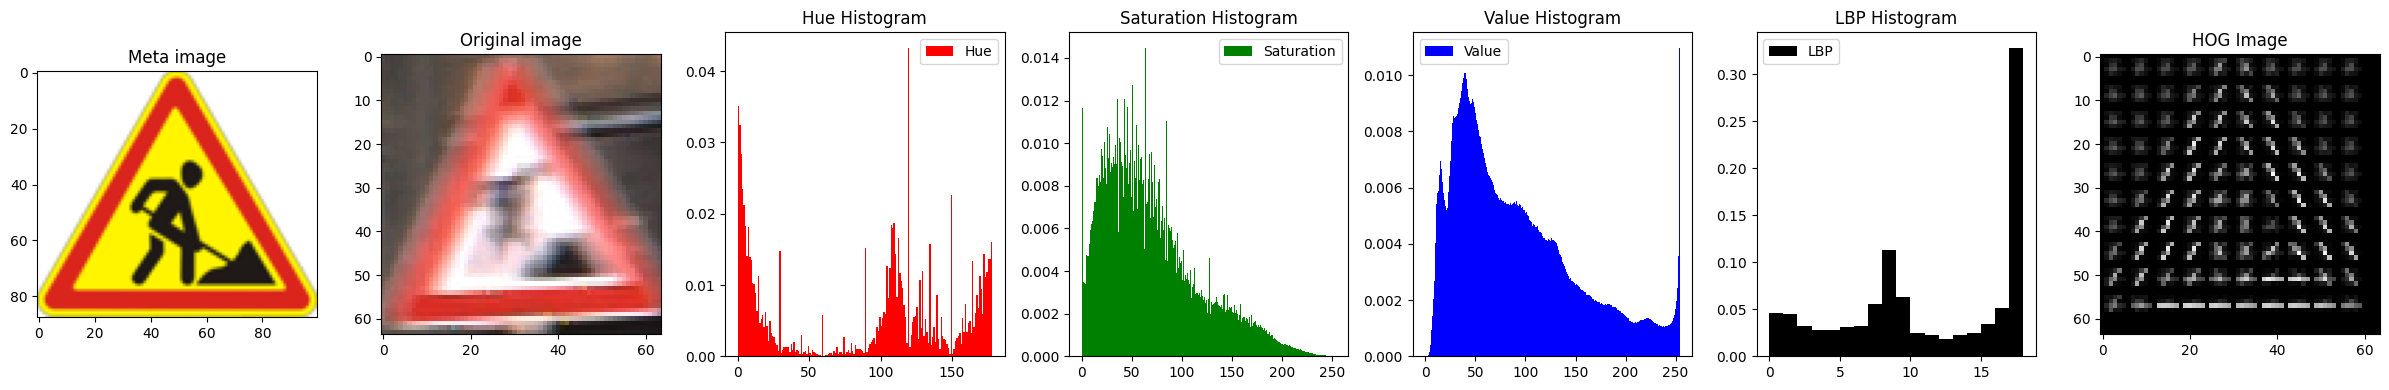

Class:			26 
Description:		Traffic signals ahead
Number of samples:	600


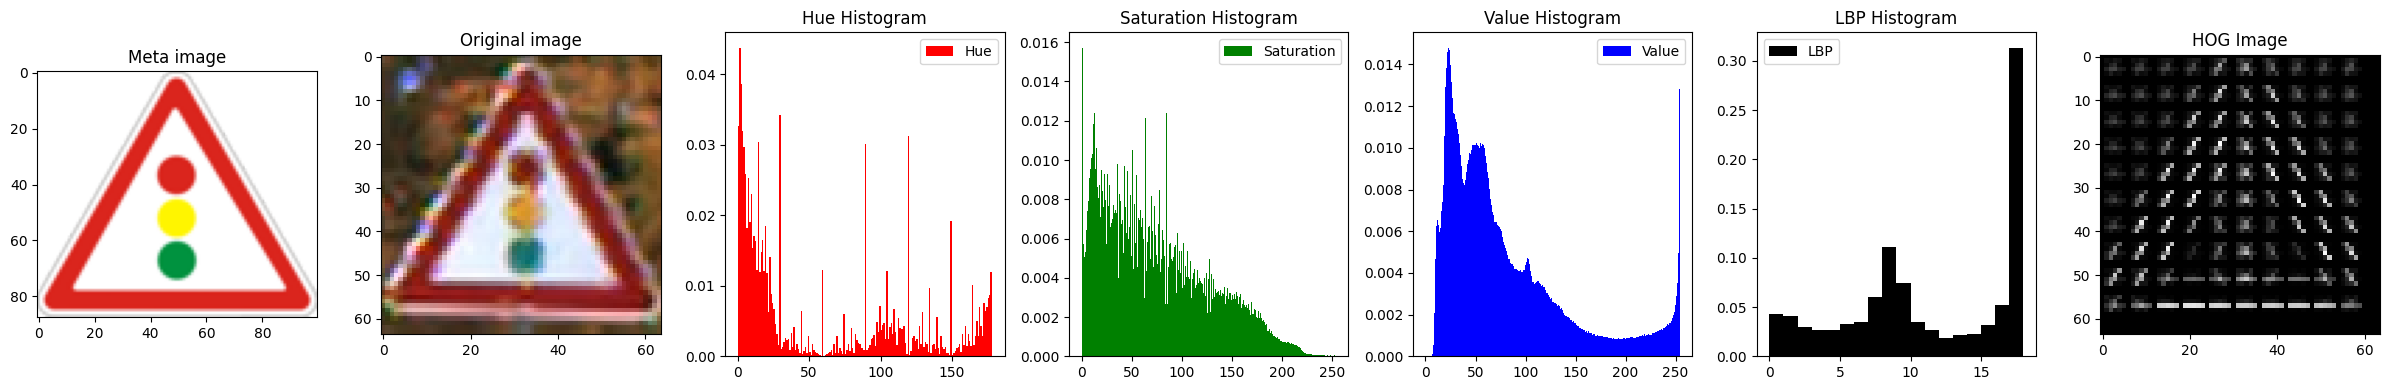

Class:			27 
Description:		Pedestrian crossing
Number of samples:	240


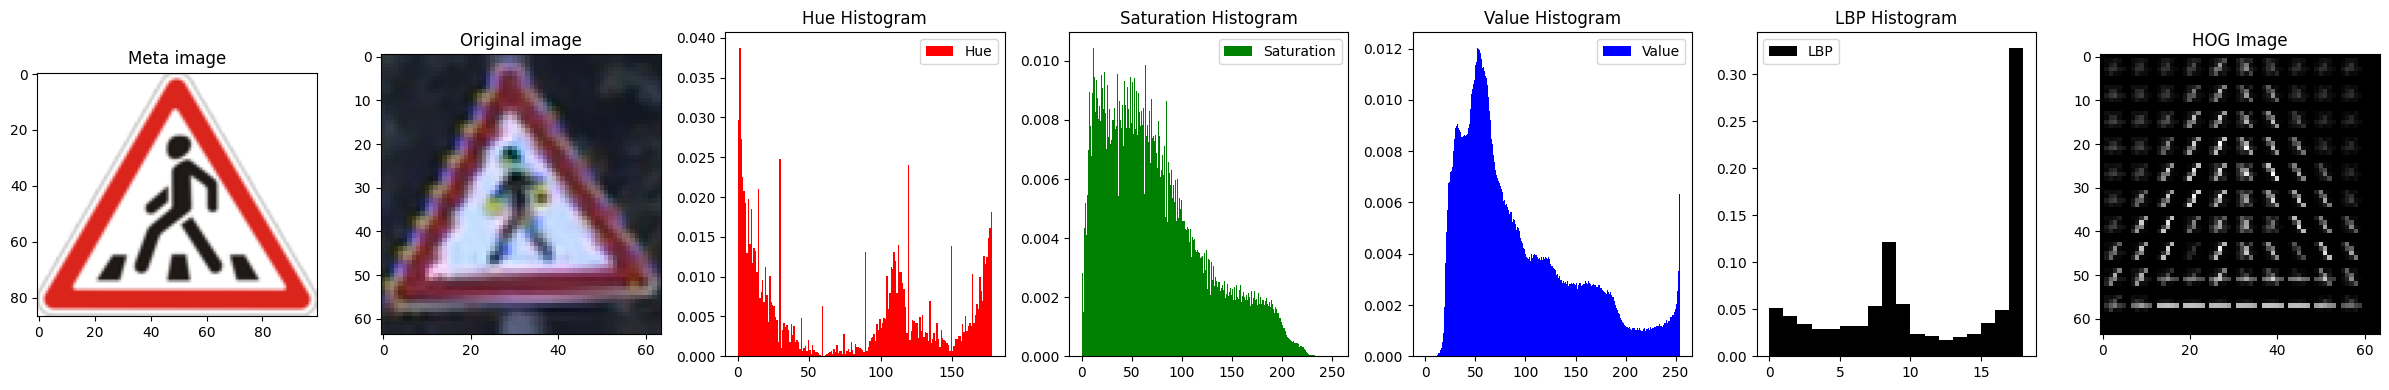

Class:			28 
Description:		Watch for children
Number of samples:	540


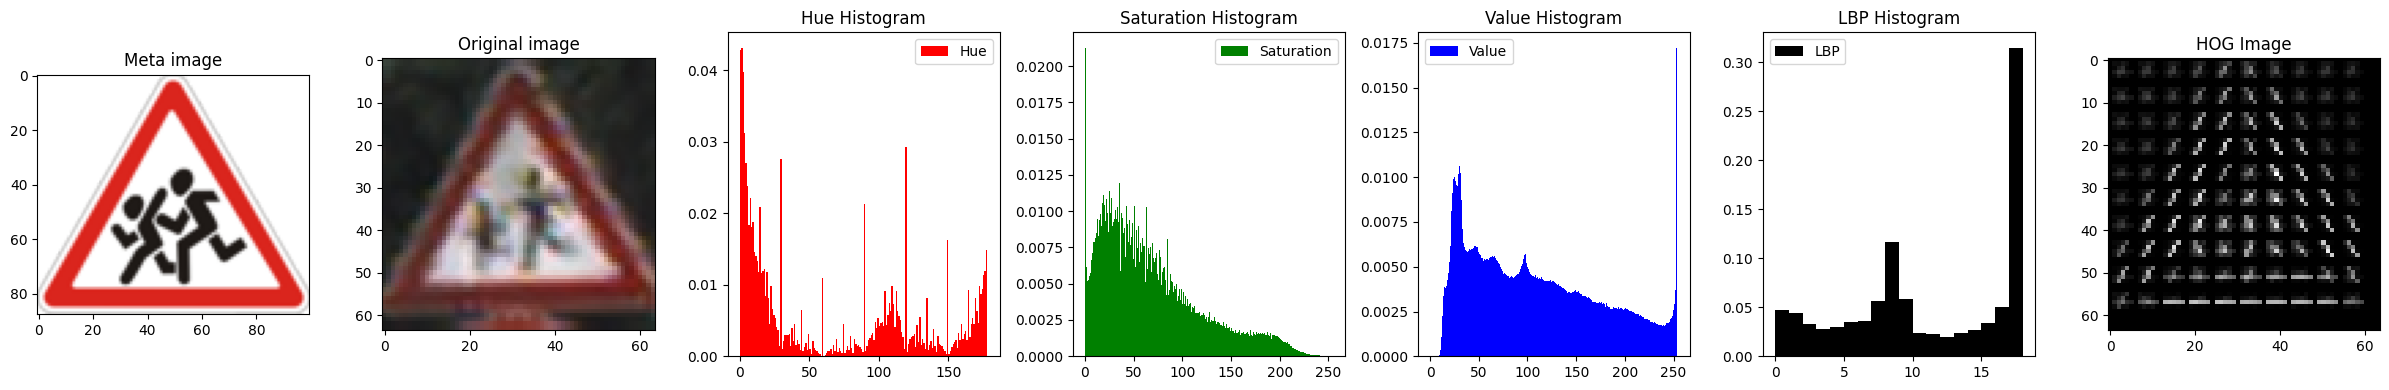

Class:			29 
Description:		Bicycle crossing
Number of samples:	270


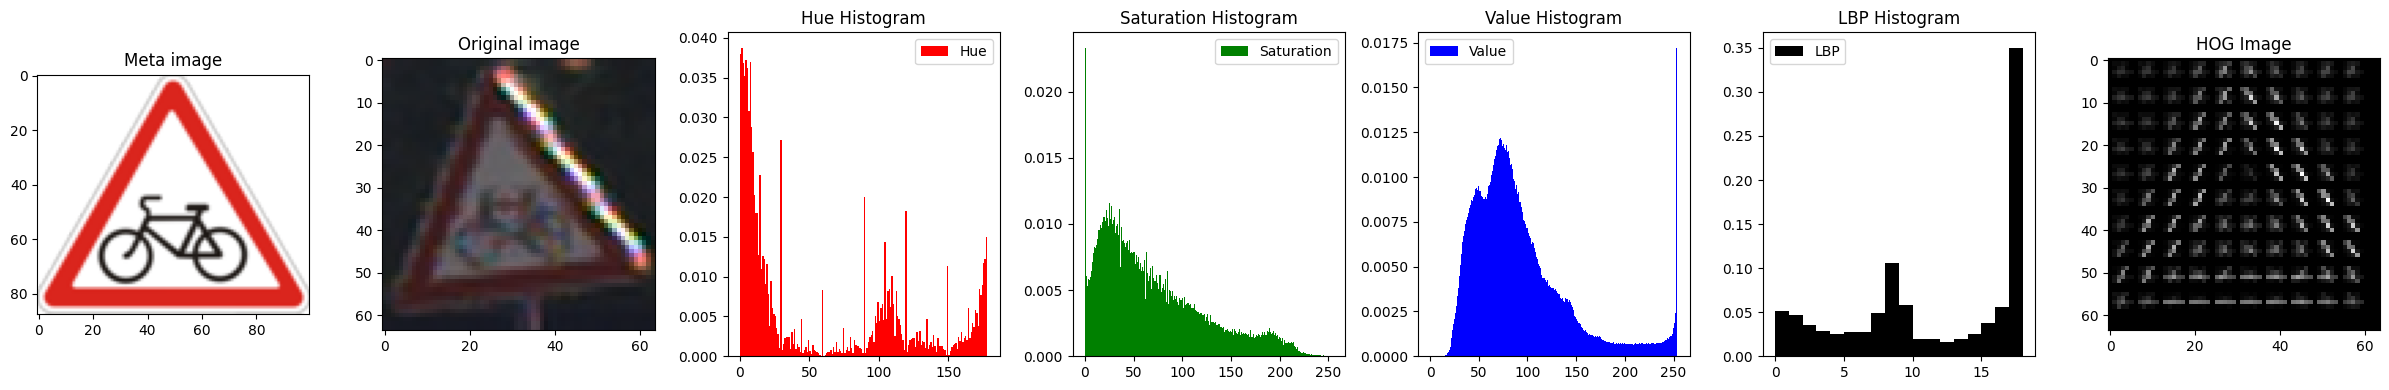

Class:			30 
Description:		Ice/snow road ahead
Number of samples:	450


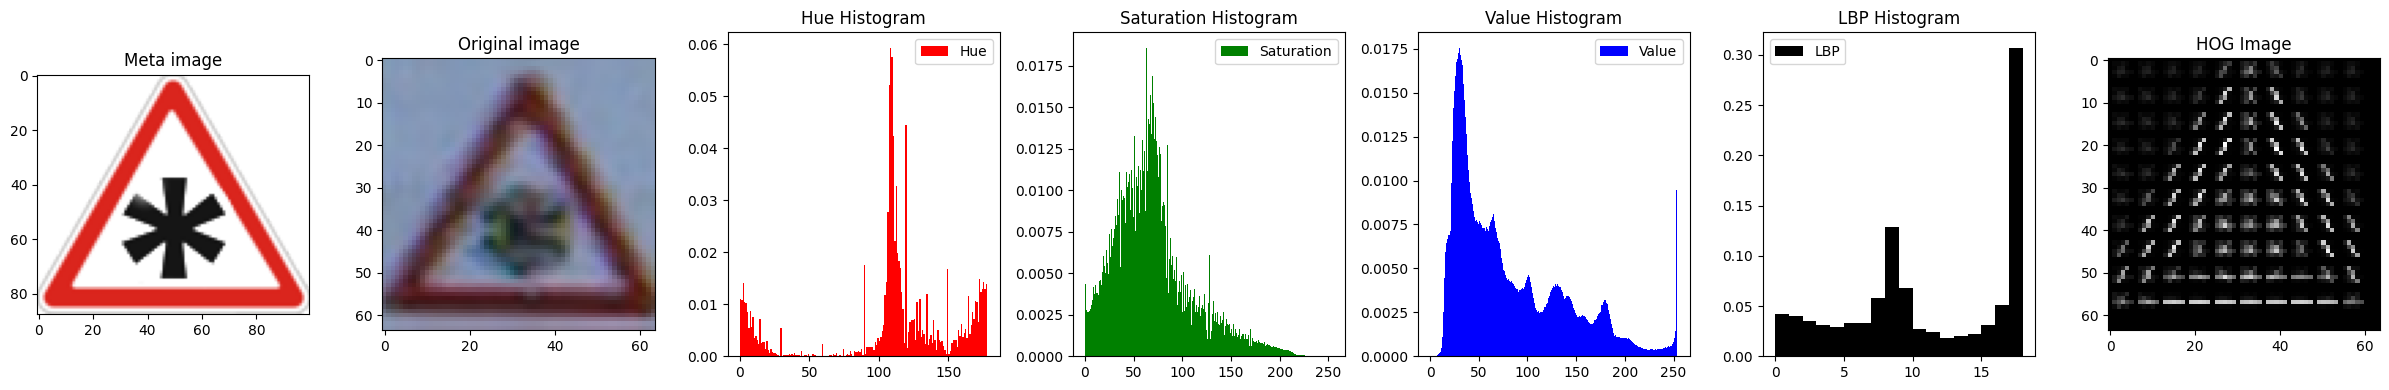

Class:			31 
Description:		Wild animal crossing
Number of samples:	780


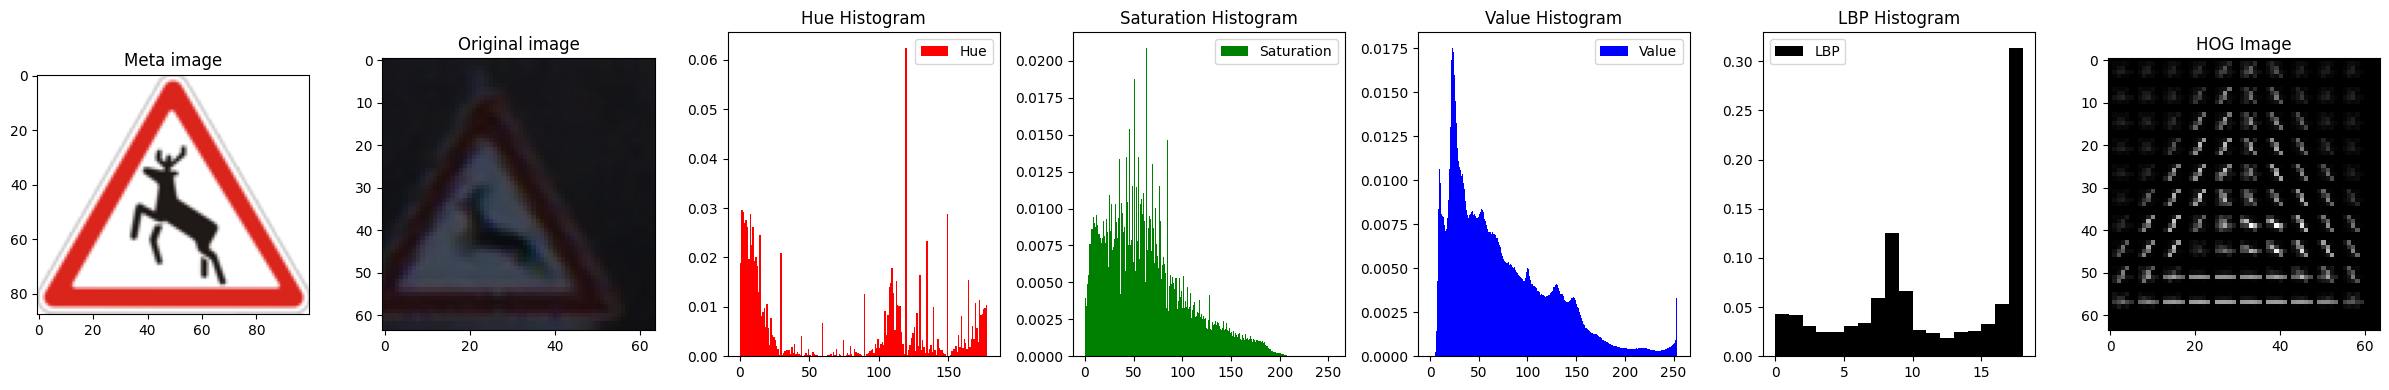

Class:			32 
Description:		End of all restrictions
Number of samples:	240


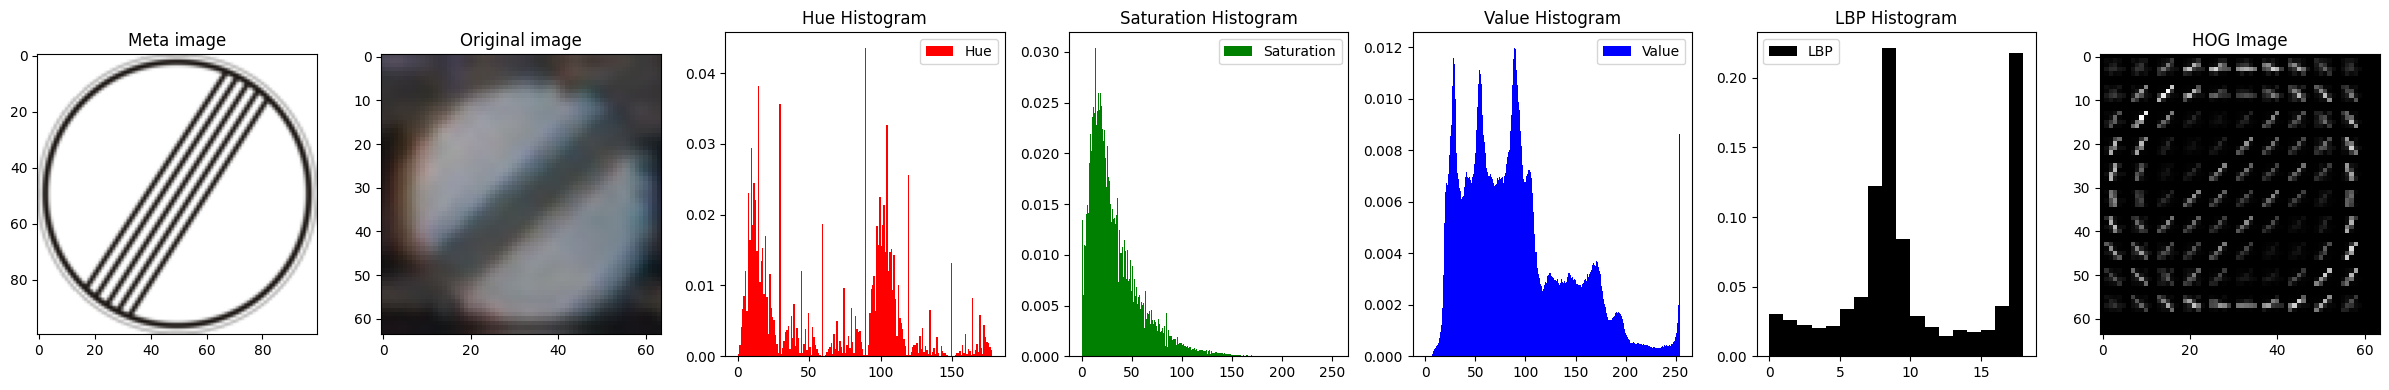

Class:			33 
Description:		Turn right ahead
Number of samples:	689


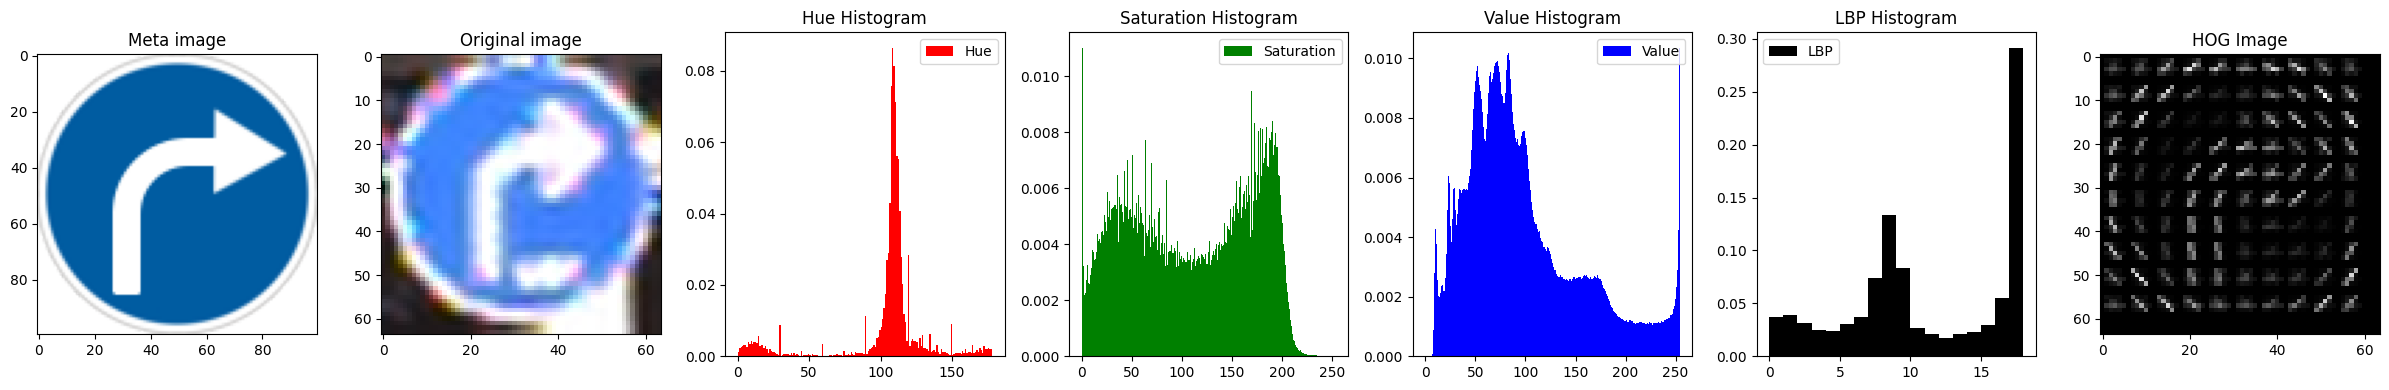

Class:			34 
Description:		Turn left ahead
Number of samples:	420


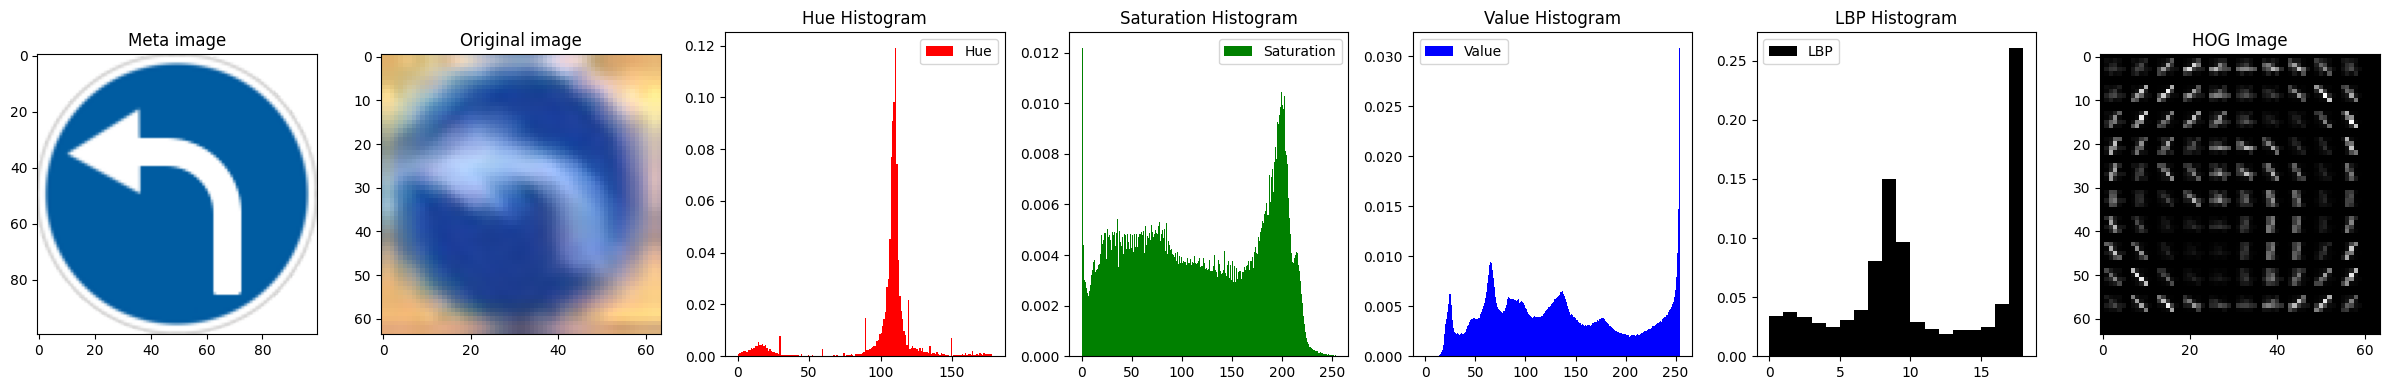

Class:			35 
Description:		Ahead only
Number of samples:	1200


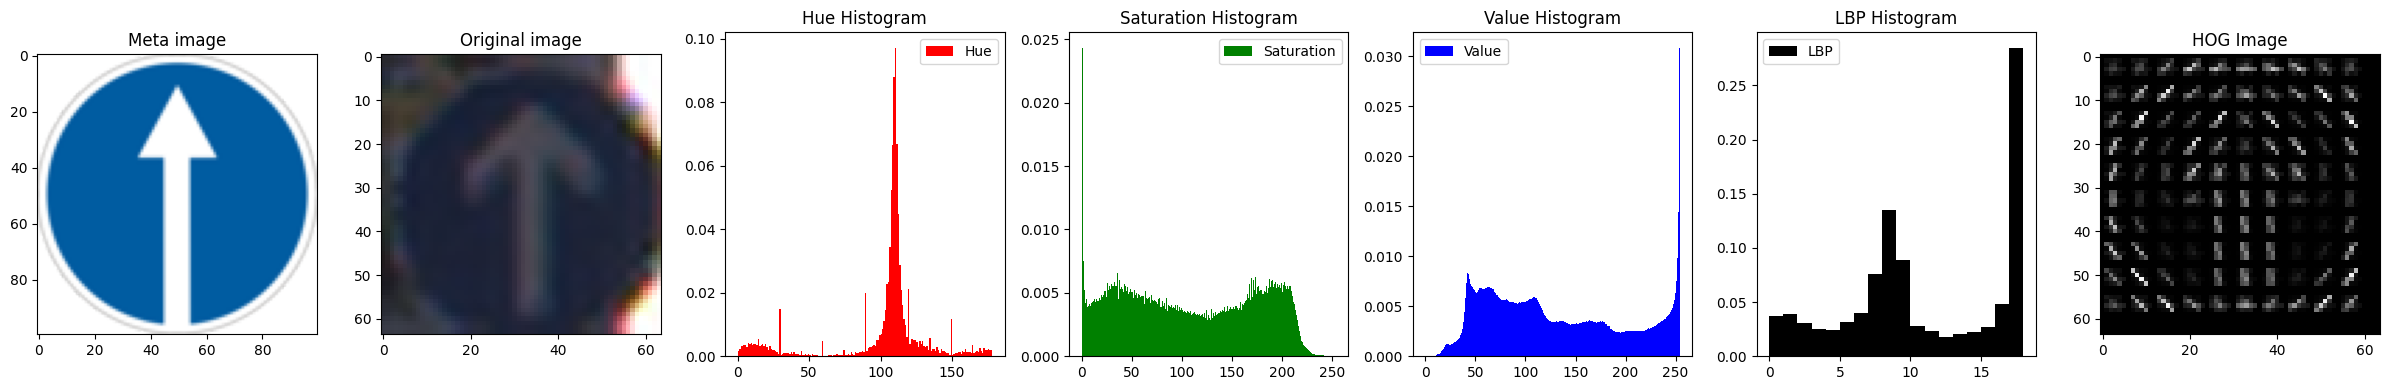

Class:			36 
Description:		Ahead or turn right only
Number of samples:	390


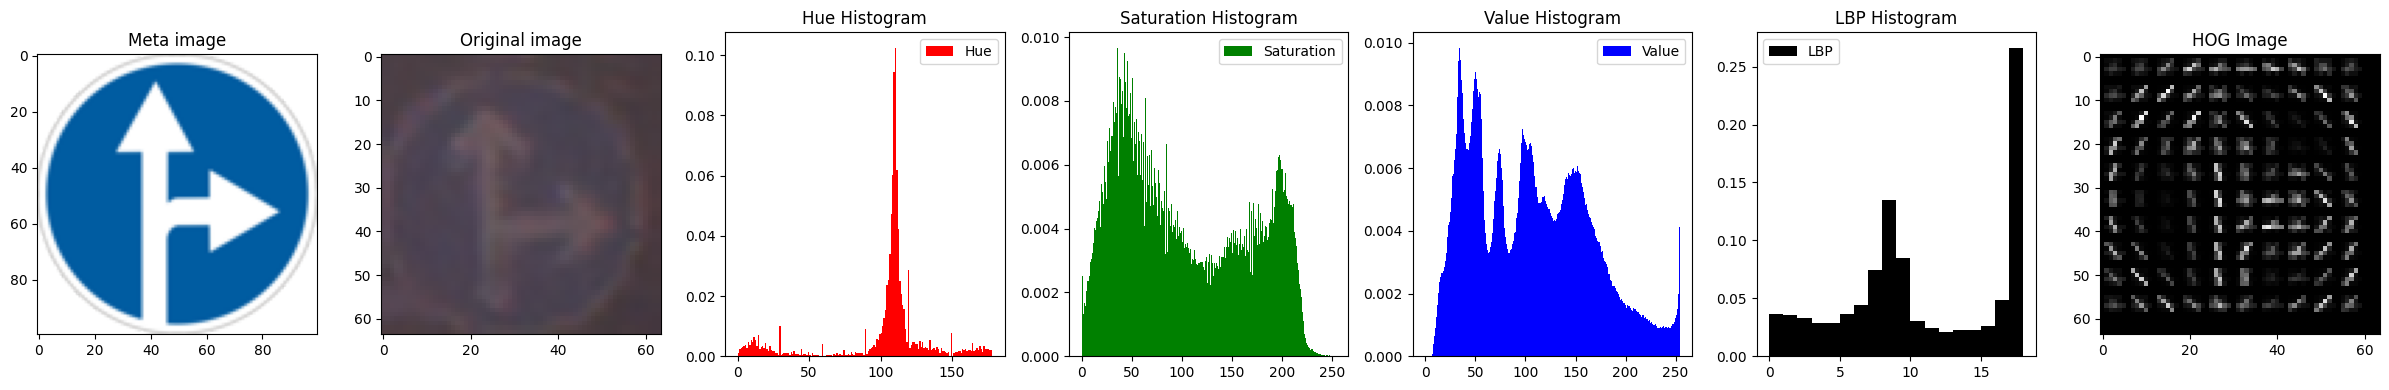

Class:			37 
Description:		Ahead or left turn only
Number of samples:	210


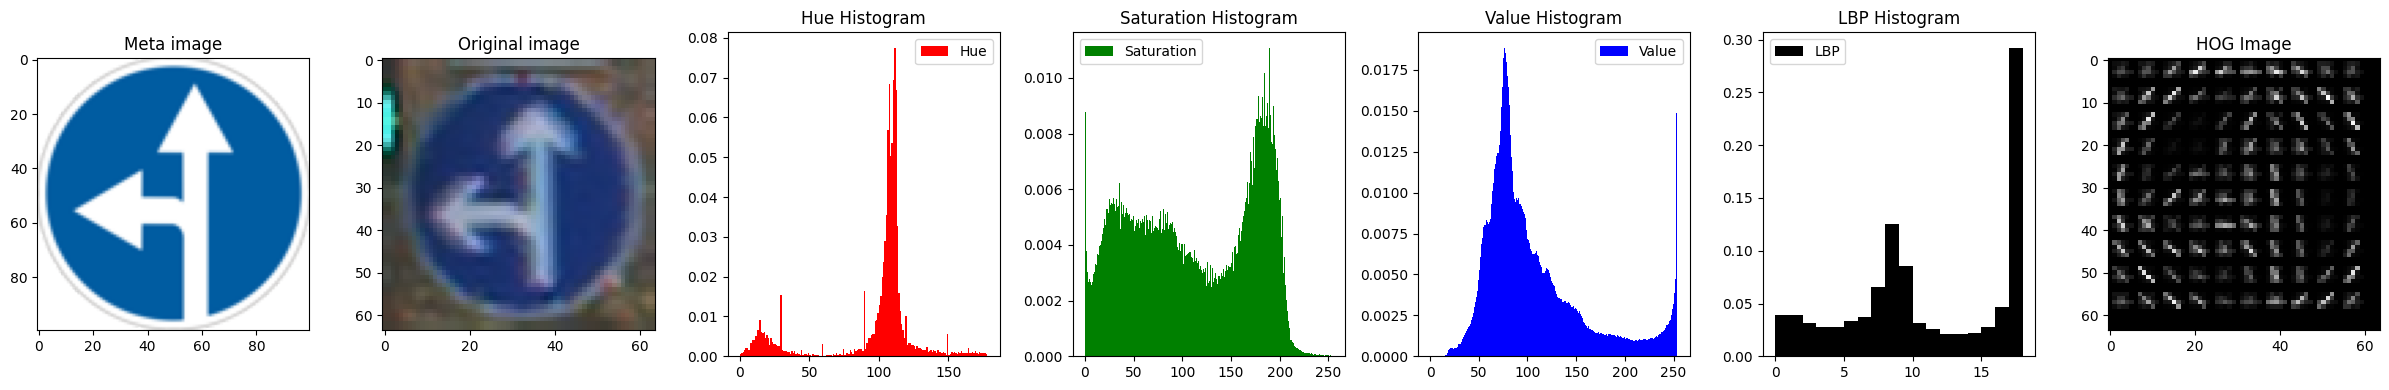

Class:			38 
Description:		Pass by on right
Number of samples:	2070


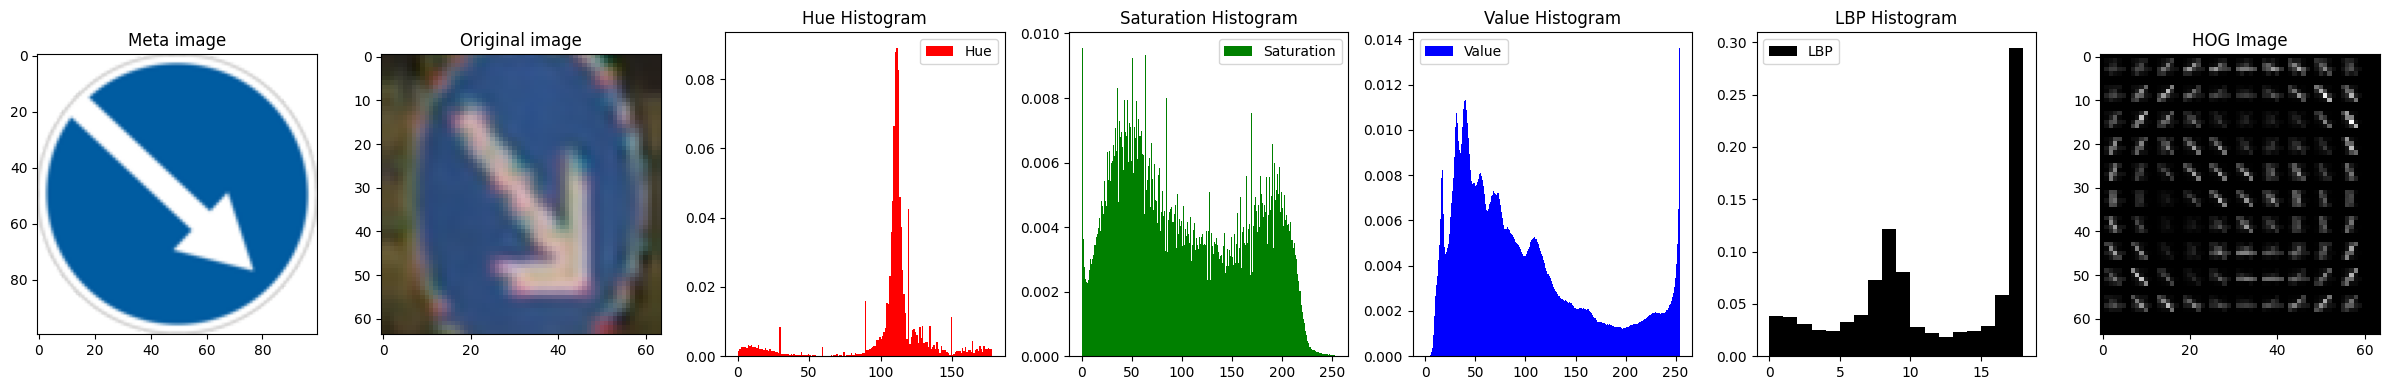

Class:			39 
Description:		Pass by on left
Number of samples:	300


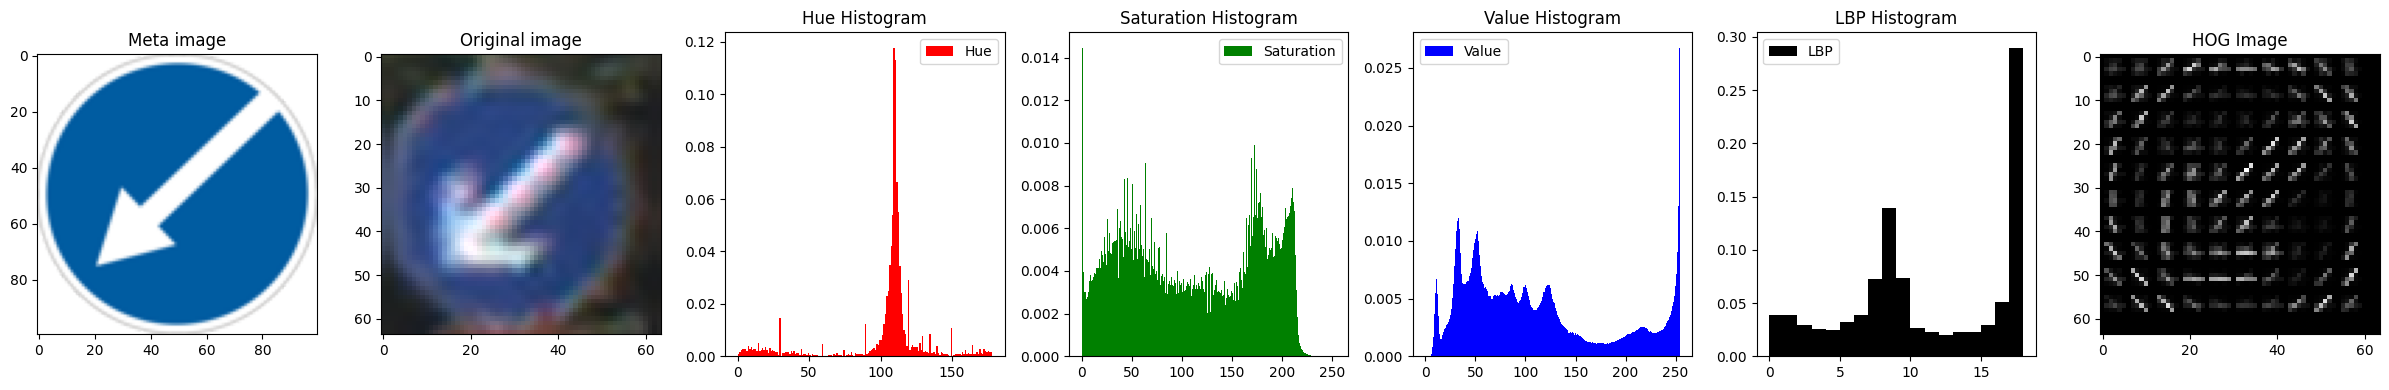

Class:			40 
Description:		Round about
Number of samples:	360


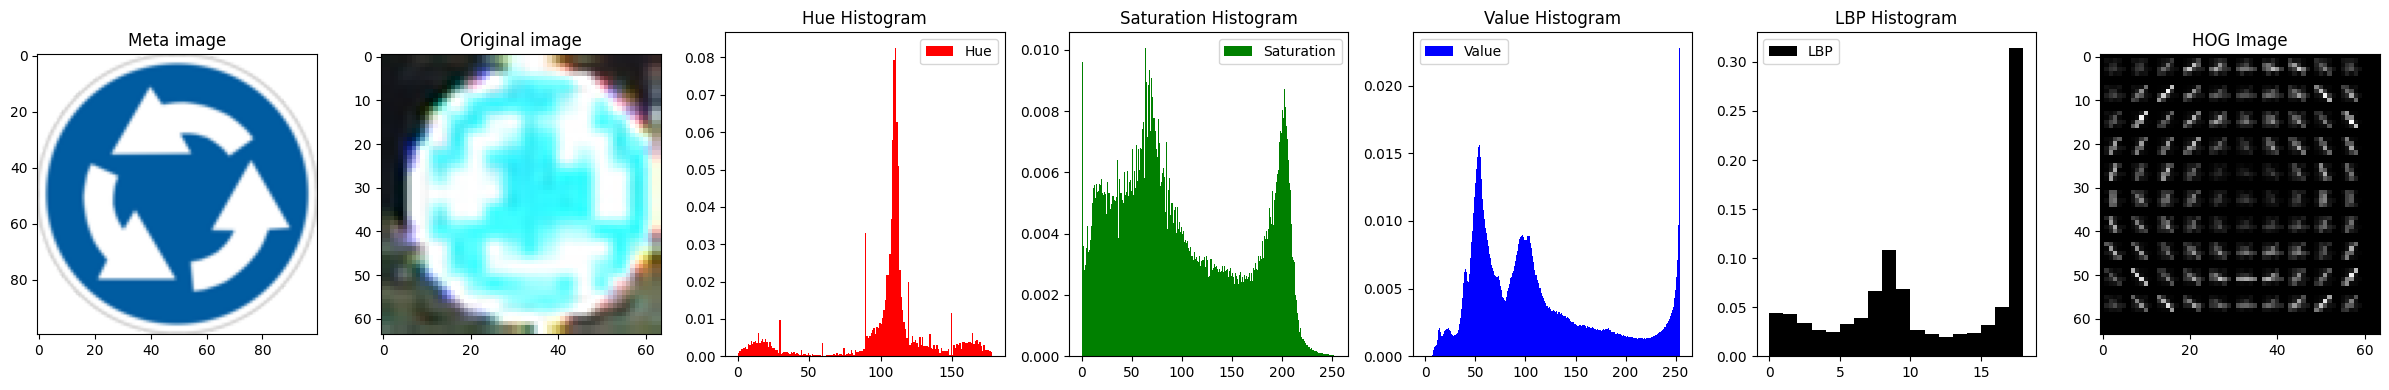

Class:			41 
Description:		End of no passing zone
Number of samples:	240


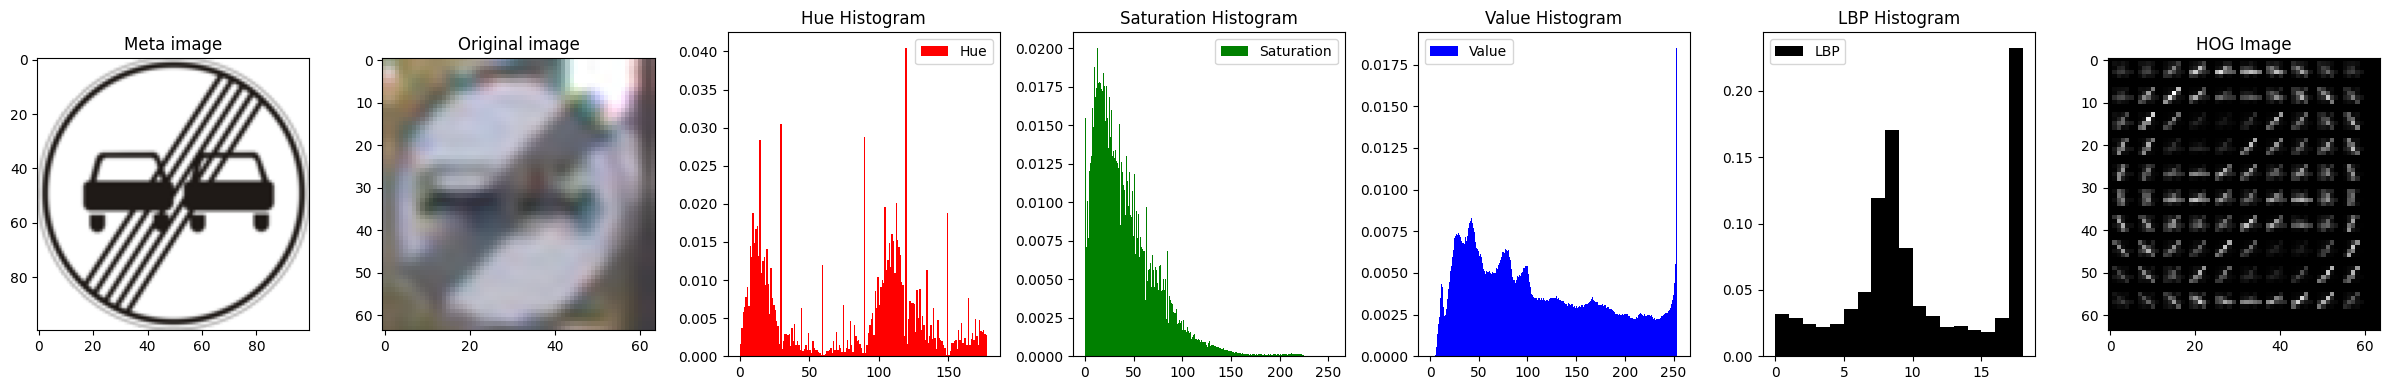

Class:			42 
Description:		End of no passing zone for trucks
Number of samples:	240


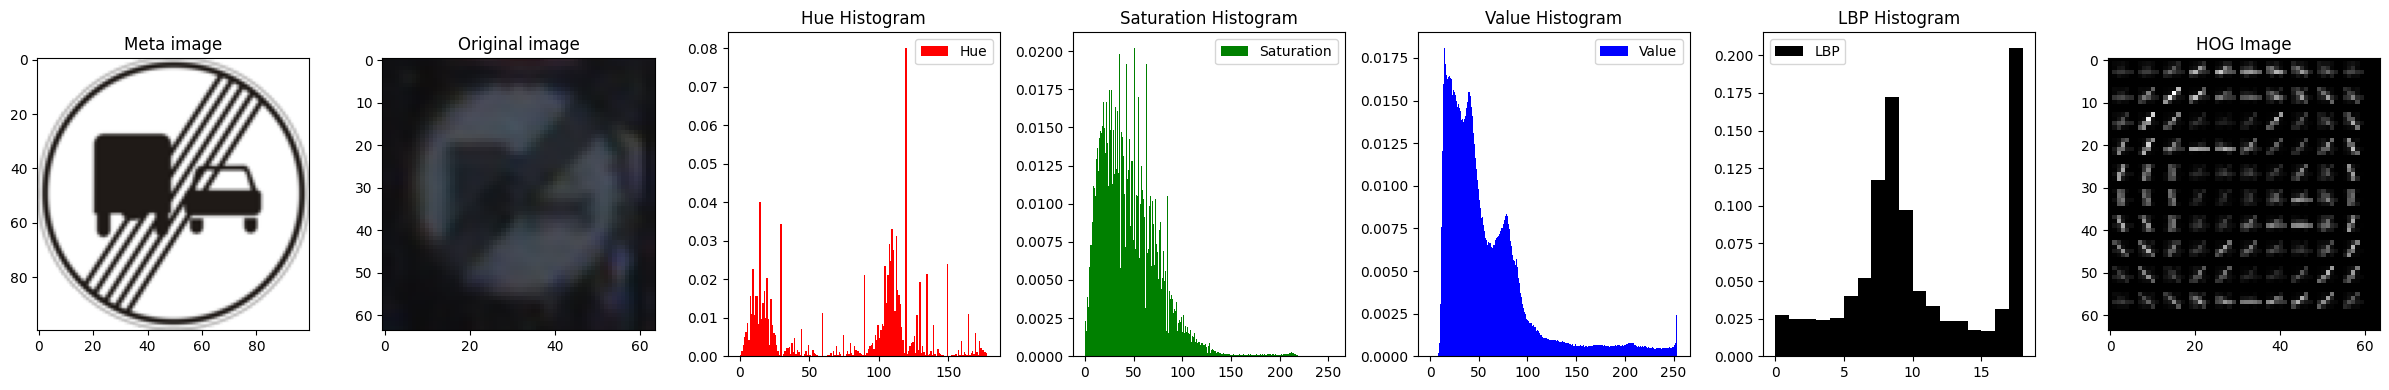

In [7]:
## There are a certain number of images that have no SIFT features
## this code will print out the index of those images.
## We Should exclude them from the dataset
## There are 46 images with no SIFT in the train image set
## There are 6 images  with no SIFT in the test image set
##
# for i in range(dft.height):
#     array = np.load(BytesIO(dft['SIFT_Features'][i]))
#     if array.shape[0] == 1 and not array.any():
#         print(f'{i} ClassId: {dft["ClassId"][i]}')

# This is the slow way to iterate through a dataframe
h_ymin = 0
h_ymax = (
    0.15  # This will clip some high values but provide better overall visualization
)
random_seed = 42
num_samples_per_class = 5

for i in range(43):
    class_members = dft.filter(pl.col("ClassId") == i)

    print(132 * "=")
    print(f"Class:\t\t\t{i} ")
    print(f"Description:\t\t{class_members['Description'][0]}")
    print(f"Number of samples:\t{class_members.height}")
    for j, sample in enumerate(class_members.iter_rows(named=True)):
        if j == 0:
            stacked_hue_hist = np.asarray(sample["Hue_Hist"])
            stacked_sat_hist = np.asarray(sample["Saturation_Hist"])
            stacked_val_hist = np.asarray(sample["Value_Hist"])
            stacked_lbp_hist = np.asarray(sample["LBP_Hist"])
            stacked_hog_image = np.load(BytesIO(sample["HOG_Image"]))
        else:
            stacked_hue_hist = np.dstack(
                (stacked_hue_hist, np.asarray(sample["Hue_Hist"]))
            )
            stacked_sat_hist = np.dstack(
                (stacked_sat_hist, np.asarray(sample["Saturation_Hist"]))
            )
            stacked_val_hist = np.dstack(
                (stacked_val_hist, np.asarray(sample["Value_Hist"]))
            )
            stacked_lbp_hist = np.dstack(
                (stacked_lbp_hist, np.asarray(sample["LBP_Hist"]))
            )
            stacked_hog_image = np.dstack(
                (stacked_hog_image, np.load(BytesIO(sample["HOG_Image"])))
            )

    class_mean_hue_hist = np.mean(np.squeeze(stacked_hue_hist), axis=1)
    class_mean_hue_hist = class_mean_hue_hist[1:-1]
    class_mean_hue_edges = np.histogram_bin_edges(
        class_mean_hue_hist, bins=178, range=(0, 178)
    )
    class_mean_hue_centers = 0.5 * (
        class_mean_hue_edges[1:] + class_mean_hue_edges[:-1]
    )

    class_mean_sat_hist = np.mean(np.squeeze(stacked_sat_hist), axis=1)
    class_mean_sat_hist = class_mean_sat_hist[1:-1]
    class_mean_sat_edges = np.histogram_bin_edges(
        class_mean_sat_hist, bins=254, range=(0, 254)
    )
    class_mean_sat_centers = 0.5 * (
        class_mean_sat_edges[1:] + class_mean_sat_edges[:-1]
    )

    class_mean_val_hist = np.mean(np.squeeze(stacked_val_hist), axis=1)
    class_mean_val_hist = class_mean_val_hist[1:-1]
    class_mean_val_edges = np.histogram_bin_edges(
        class_mean_val_hist, bins=254, range=(0, 254)
    )
    class_mean_val_centers = 0.5 * (
        class_mean_val_edges[1:] + class_mean_val_edges[:-1]
    )

    class_mean_lbp_hist = np.mean(np.squeeze(stacked_lbp_hist), axis=1)
    class_mean_lbp_edges = np.histogram_bin_edges(
        class_mean_lbp_hist,
        bins=len(class_mean_lbp_hist),
        range=(0, len(class_mean_lbp_hist)),
    )
    class_mean_lbp_centers = 0.5 * (
        class_mean_lbp_edges[1:] + class_mean_lbp_edges[:-1]
    )

    class_mean_hog_image = np.mean(np.squeeze(stacked_hog_image), axis=2)

    # Plot original image
    nrows = 1
    ncols = 7
    fig = plt.figure(figsize=(24, 4))

    meta_image = np.load(BytesIO(class_members["Meta_Image"][0]))
    meta_image = (meta_image * 255).astype(np.uint8)
    ax = fig.add_subplot(nrows, ncols, 1)
    ax.imshow(meta_image)
    ax.set_title("Meta image")

    original_image = np.load(BytesIO(class_members["Image"][random_seed]))
    original_image = (original_image * 255).astype(np.uint8)
    ax = fig.add_subplot(nrows, ncols, 2)
    ax.imshow(original_image)
    ax.set_title("Original image")

    ax = fig.add_subplot(nrows, ncols, 3)
    plt.bar(
        class_mean_hue_centers,
        normalize_histogram(class_mean_hue_hist),
        width=(class_mean_hue_edges[1] - class_mean_hue_edges[0]),
        color="red",
        label="Hue",
    )
    ax.legend()
    ax.set_title("Hue Histogram")
    del class_mean_hue_hist
    del class_mean_hue_edges
    del class_mean_hue_centers

    ax = fig.add_subplot(nrows, ncols, 4)
    plt.bar(
        class_mean_sat_centers,
        normalize_histogram(class_mean_sat_hist),
        width=(class_mean_sat_edges[1] - class_mean_sat_edges[0]),
        color="green",
        label="Saturation",
    )
    ax.legend()
    ax.set_title("Saturation Histogram")
    del class_mean_sat_hist
    del class_mean_sat_edges
    del class_mean_sat_centers

    ax = fig.add_subplot(nrows, ncols, 5)
    plt.bar(
        class_mean_val_centers,
        normalize_histogram(class_mean_val_hist),
        width=(class_mean_val_edges[1] - class_mean_val_edges[0]),
        color="blue",
        label="Value",
    )
    ax.legend()
    ax.set_title("Value Histogram")
    del class_mean_val_hist
    del class_mean_val_edges
    del class_mean_val_centers

    ax = fig.add_subplot(nrows, ncols, 6)
    plt.bar(
        class_mean_lbp_centers,
        normalize_histogram(class_mean_lbp_hist),
        width=(class_mean_lbp_edges[1] - class_mean_lbp_edges[0]),
        color="black",
        label="LBP",
    )
    ax.legend()
    ax.set_title("LBP Histogram")
    del class_mean_lbp_hist
    del class_mean_lbp_edges
    del class_mean_lbp_centers

    ax = fig.add_subplot(nrows, ncols, 7)
    ax.imshow(class_mean_hog_image, cmap="gray")
    ax.set_title("HOG Image")

    plt.tight_layout()
    plt.show()